In [145]:
# TO link colab with google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [146]:
import pandas as pd

# Load the dataset from an Excel file
file_path = '/content/drive/MyDrive/Colab Notebooks/MinneMUDAC2025/Novice.xlsx'

try:
    # If your file has multiple sheets, you can specify the sheet with sheet_name parameter (e.g., sheet_name=0 or sheet_name='Sheet1')
    df = pd.read_excel(file_path, sheet_name=0)
except Exception as e:
    error = str(e)

# Display the result
if 'df' in locals():
    data_head = df.head()
else:
    data_head = error

print(data_head)


      Match ID 18Char   Stage           Little ID           Big ID  \
0  a1v2J0000028pRvQAI  Closed  0032J00003PLe29QAD  0032J00003PhDOI   
1  a1v2J000002uR0JQAU  Closed  0032J00003PfZ6OQAV  0032J00003PgoV1   
2  a1v2J0000027NsOQAU  Closed  0032J00003PLeoRQAT  0032J00003Ph0MT   
3  a1v2J0000027dtOQAQ  Active  0032J00003PLeoRQAT  0032J00003Ph14N   
4  a1v2J0000028enKQAQ  Closed  0032J00003PfZ6QQAV  0032J00003Ph14j   

   Big County  Big Age              Big Occupation Big: Military  \
0    Hennepin       40                  Unemployed           NaN   
1  Washington       65       Tech: Research/Design           NaN   
2      Ramsey       45                    Military           NaN   
3    Hennepin       61            Finance: Banking           NaN   
4      Ramsey       29  Human Services: Non-Profit           NaN   

  Big Approved Date Big Level of Education  ...  \
0               NaT         Masters Degree  ...   
1        2018-04-11                    NaN  ...   
2               N

In [153]:
columns_of_interest = [
    'Stage', 'Closure Reason', 'Match Length',
    'Big County', 'Big Age', 'Big Occupation', 'Big: Military', 'Big Level of Education',
    'Big Languages', 'Big Gender', 'Big Race/Ethnicity',
    'Big Days Acceptance to Match',
    'Big Open to Cross-Gender Match', 'Big Contact: Former Big/Little',
    'Big Contact: Marital Status',
    'Little Contact: Language(s) Spoken', 'Little Gender', 'Little Participant: Race/Ethnicity',
    'Program Type', 'Match Activation Date']
df_subset = df[columns_of_interest]

print(df_subset.head().to_markdown())

|    | Stage   | Closure Reason                                  |   Match Length | Big County   |   Big Age | Big Occupation             |   Big: Military | Big Level of Education   | Big Languages   | Big Gender   | Big Race/Ethnicity                            |   Big Days Acceptance to Match |   Big Open to Cross-Gender Match |   Big Contact: Former Big/Little |   Big Contact: Marital Status |   Little Contact: Language(s) Spoken | Little Gender   | Little Participant: Race/Ethnicity            | Program Type   | Match Activation Date   |
|---:|:--------|:------------------------------------------------|---------------:|:-------------|----------:|:---------------------------|----------------:|:-------------------------|:----------------|:-------------|:----------------------------------------------|-------------------------------:|---------------------------------:|---------------------------------:|------------------------------:|-------------------------------------:|:-----------

In [173]:
import pandas as pd
import numpy as np

# Clean Data

stage_binary = {
    'Active': 0,
    'Pending Closure':1,
    'Closed': 1
}

# Future analysis shows non-(fe)male genders are too little in count, causing high variance and thus not good for Cox regression
gender_binary = {
    'Female': 0,
    'Male': 1,
    'Genderqueer/Nonbinary': 'Unknown',
    'Prefer not to say': 'Unknown',
    'Trans Female' : 'Unknown',
    'Trans Male': 'Unknown'
}

county_corrections = {
    "Hennepin County": "Hennepin",
    "Henepin": "Hennepin",
    "Hennpin": "Hennepin",
    "Ramesy": "Ramsey",
    "Rice County": "Rice",
    "St. Croix County, WI": "St. Croix",
    "St. Croix County": "St. Croix",
    "LeSeuer": "Le Sueur",
    "MN": "Minnesota",
    "mn": "Minnesota",
    "New Castle County": "New Castle",
    "US": "United States",
    "United States of America": "United States"
}

not_counties = {
    "Testing County": "Unknown",
    "Minnesota": "Unknown",
    "Outside state": "Unknown",
    "United States": "Unknown",
    "California": "Unknown",
    "Other": "Unknown"
}

binary_category_corrections = {
    'No': 0,
    'Yes': 1
}

for var in columns_of_interest:
    match var:
        case "Stage":
            df_subset.loc[:, var] = pd.to_numeric(df_subset[var].fillna("Unknown").infer_objects(copy=False).replace(stage_binary))
        case "Big County":
            df_subset.loc[:, var] = df_subset[var].fillna("Unknown").infer_objects(copy=False).replace(county_corrections).replace(not_counties)
        case "Big Occupation":
            df_subset.loc[:, var] = df_subset[var].fillna("Unknown").infer_objects(copy=False).str.split(':').str[0]
        case "Big Race/Ethnicity":
            df_subset.loc[:, var] = df_subset[var].fillna("Prefer not to say").infer_objects(copy=False)
        case "Big Gender":
            df_subset.loc[:, var] = df_subset[var].fillna("Unknown").infer_objects(copy=False).replace(gender_binary)
        case "Little Gender":
            df_subset.loc[:, var] = df_subset[var].fillna("Unknown").infer_objects(copy=False).replace(gender_binary)
        case "Big Days Acceptance to Match":
            df_subset.loc[:, var] = df_subset[var].abs().fillna(-1).infer_objects(copy=False).astype(int)
        case "Big Days Interview to Acceptance":
            df_subset.loc[:, var] = df_subset[var].abs().fillna(-1).infer_objects(copy=False).astype(int)
        case "Big Days Interview to Match":
            df_subset.loc[:, var] = df_subset[var].abs().fillna(-1).infer_objects(copy=False).astype(int)
        case "Big Re-Enroll":
            df_subset.loc[:, var] = df_subset[var].fillna("Unknown").infer_objects(copy=False).replace(binary_category_corrections)
        case _:
            df_subset.loc[:, var] = df_subset[var].replace('', np.nan).infer_objects(copy=False).fillna("Unknown")
            print(var)

    uniques = df_subset[var].unique()
    try: uniques = np.sort(uniques)
    except: pass
    print(uniques)
    print()

    df_subset = df_subset[df_subset["Big Gender"] != 'Unknown']
    df_subset = df_subset[df_subset["Little Gender"] != 'Unknown']

    print(df_subset['Big Open to Cross-Gender Match'].value_counts())





[0 1]

Big Open to Cross-Gender Match
Unknown    3212
Yes          34
No            3
Name: count, dtype: int64
Closure Reason
['Agency: Challenges with program/partnership'
 'Agency: Concern with Volunteer re: child safety' 'COVID impact'
 'Changing Match Type' 'Child/Family: Feels incompatible with volunteer'
 'Child/Family: Infraction of match rules/agency policies'
 'Child/Family: Lost contact with agency'
 'Child/Family: Lost contact with volunteer'
 'Child/Family: Lost contact with volunteer/agency' 'Child/Family: Moved'
 'Child/Family: Moved out of service area'
 'Child/Family: Moved within service area'
 'Child/Family: Time constraints' 'Child/Family: Unrealistic expectations'
 'Child: Changed school/site' 'Child: Family structure changed'
 'Child: Graduated' 'Child: Lost interest' 'Child: Severity of challenges'
 'Successful match closure' 'Unknown'
 'Volunteer: Changed workplace/school partnership' 'Volunteer: Deceased'
 'Volunteer: Feels incompatible with child/family' 'Volu

<ipython-input-173-4060e9394571>:55: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_subset.loc[:, var] = pd.to_numeric(df_subset[var].fillna("Unknown").infer_objects(copy=False).replace(stage_binary))
<ipython-input-173-4060e9394571>:63: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_subset.loc[:, var] = df_subset[var].fillna("Unknown").infer_objects(copy=False).replace(gender_binary)
<ipython-input-173-4060e9394571>:65: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call r

In [155]:
# Customized modifications for special entries columns:
# Multiple entries 'Big Languages', 'Big Race/Ethnicity', 'Little Participant: Race/Ethnicity',

subcategory_delimiter = " >> "

# Special one-hot encoding
# Get the df and columns whose entries are ;-delimited entries.
# Make one-hot encoding schematic for the columns
# Keep relative order of the columns
# replacements = {
#     'column_to_replace_1': {
#         'pos': 3,
#         'new_cols': {
#             'new_col_1': 4,
#             'new_col_2': 5
#         }
#     }, ...
# }
def one_hot_encode_multi_entries_plan(df, columns):
  replacements = {}
  for col in columns:
    replace_data = {}
    # Get list of delimiter-split actual unique elements
    uniques = df_subset[col].unique()
    indvs = []
    for unique in uniques:
      splitUnique = unique.split(';')
      for split in splitUnique:
        split = split.strip()
        if split != '': indvs.append(split.strip())
    indvs = sorted(list(set(indvs)))

    # New columns
    col_position = df.columns.get_loc(col)
    replace_data['pos'] = col_position
    newCols = {}
    curNewPos = col_position + 1
    for indv in indvs:
      newCol = f"{col}{subcategory_delimiter}{indv}"
      newCols[newCol] = curNewPos
      curNewPos += 1
    replace_data['new_cols'] = newCols
    replacements[col] = replace_data
  return replacements

def reconstruct_multi_entries_dataframe(df, replacements):
    # List to hold the final column order
    final_columns = []

    # Iterate over the original DataFrame's columns
    for col in df.columns:
        if col in replacements:
          # Insert dummy columns at the end of the df and at the right place in final_columns order
          dummy_cols = list(replacements[col]['new_cols'].keys())
          final_columns.extend(dummy_cols)
          dummies = df[col].str.get_dummies(sep=';')
          original_dummy_columns = dummies.columns.tolist()
          rename_dict = dict(zip(original_dummy_columns, dummy_cols))
          dummies.rename(columns=rename_dict, inplace=True)
          df = pd.concat([df.drop(col, axis=1), dummies], axis=1)

        elif not any(col in rep['new_cols'] for rep in replacements.values()):
          # Add the column if it's not a newly created dummy column
          final_columns.append(col)

    # Reorder the DataFrame based on the final_columns list
    df = df[final_columns]
    return df

multi_entries_replacements = one_hot_encode_multi_entries_plan(df_subset, ['Big Languages', 'Big Race/Ethnicity', 'Little Participant: Race/Ethnicity'])
df_multi_encoded = reconstruct_multi_entries_dataframe(df_subset, multi_entries_replacements)
print(df_multi_encoded.head().to_markdown())


|    |   Stage | Closure Reason                                  |   Match Length | Big County   |   Big Age | Big Occupation   | Big: Military   | Big Level of Education   |   Big Languages >> African Languages (Swahili, Bantu) |   Big Languages >> American Sign Language |   Big Languages >> Arabic |   Big Languages >> Asian: Other |   Big Languages >> Chinese |   Big Languages >> Creole |   Big Languages >> Eastern European (Czech, Slovak) |   Big Languages >> English |   Big Languages >> French |   Big Languages >> German |   Big Languages >> Hebrew |   Big Languages >> Hmong |   Big Languages >> Indian (Hindi, Punjabi) |   Big Languages >> Italian |   Big Languages >> Japanese |   Big Languages >> Korean |   Big Languages >> No Preference |   Big Languages >> Nordic |   Big Languages >> Persian |   Big Languages >> Portuguese |   Big Languages >> Russian |   Big Languages >> Somali |   Big Languages >> Spanish |   Big Languages >> Turkish |   Big Languages >> Unknown |   Big Gender

In [156]:
# Customized modifications for special entries columns:
# Time: 'Match Activation Date'

import pandas as pd
from dateutil.relativedelta import relativedelta
from datetime import datetime

df_multi_n_time_encoded = df_multi_encoded.copy()
final_columns = df_multi_n_time_encoded.columns.tolist()
temp_columns = []
col = "Match Activation Date"
uTime_colName = "Months Until Now"

# Get col location
col_position = df_multi_n_time_encoded.columns.get_loc(col)
temp_columns += final_columns[:col_position]

# Convert to datetime
df_multi_n_time_encoded[col] = pd.to_datetime(df_multi_n_time_encoded[col])

# Calculate months until the current date
current_date = datetime.now()
df_multi_n_time_encoded[uTime_colName] = df_multi_n_time_encoded[col].apply(lambda x: relativedelta(current_date, x).years * 12 + relativedelta(current_date, x).months)

temp_columns.append(uTime_colName)

final_columns = temp_columns + final_columns[col_position + 1:]

df_multi_n_time_encoded = df_multi_n_time_encoded[final_columns]
print(df_multi_n_time_encoded.head().to_markdown())

|    |   Stage | Closure Reason                                  |   Match Length | Big County   |   Big Age | Big Occupation   | Big: Military   | Big Level of Education   |   Big Languages >> African Languages (Swahili, Bantu) |   Big Languages >> American Sign Language |   Big Languages >> Arabic |   Big Languages >> Asian: Other |   Big Languages >> Chinese |   Big Languages >> Creole |   Big Languages >> Eastern European (Czech, Slovak) |   Big Languages >> English |   Big Languages >> French |   Big Languages >> German |   Big Languages >> Hebrew |   Big Languages >> Hmong |   Big Languages >> Indian (Hindi, Punjabi) |   Big Languages >> Italian |   Big Languages >> Japanese |   Big Languages >> Korean |   Big Languages >> No Preference |   Big Languages >> Nordic |   Big Languages >> Persian |   Big Languages >> Portuguese |   Big Languages >> Russian |   Big Languages >> Somali |   Big Languages >> Spanish |   Big Languages >> Turkish |   Big Languages >> Unknown |   Big Gender

In [174]:
# Apply normal one-hot encodings
import pandas as pd

df_encoded = pd.DataFrame(df_multi_n_time_encoded.copy())
df_encoded = pd.get_dummies(df_encoded, prefix_sep=" >> ", dtype=int, columns=[
    'Big County', 'Big Occupation', 'Big: Military', 'Big Level of Education',
    'Big Open to Cross-Gender Match', 'Big Contact: Former Big/Little',
    'Big Contact: Marital Status',
    'Little Contact: Language(s) Spoken', 'Program Type'])

print(df_encoded.head().to_markdown())

|    |   Stage | Closure Reason                                  |   Match Length |   Big Age |   Big Languages >> African Languages (Swahili, Bantu) |   Big Languages >> American Sign Language |   Big Languages >> Arabic |   Big Languages >> Asian: Other |   Big Languages >> Chinese |   Big Languages >> Creole |   Big Languages >> Eastern European (Czech, Slovak) |   Big Languages >> English |   Big Languages >> French |   Big Languages >> German |   Big Languages >> Hebrew |   Big Languages >> Hmong |   Big Languages >> Indian (Hindi, Punjabi) |   Big Languages >> Italian |   Big Languages >> Japanese |   Big Languages >> Korean |   Big Languages >> No Preference |   Big Languages >> Nordic |   Big Languages >> Persian |   Big Languages >> Portuguese |   Big Languages >> Russian |   Big Languages >> Somali |   Big Languages >> Spanish |   Big Languages >> Turkish |   Big Languages >> Unknown |   Big Gender |   Big Race/Ethnicity >> American Indian or Alaska Native |   Big Race/Ethnic

In [175]:
# Drop low count one-hot columns with super low number of 1's, since that means super loww variance, and thus the Cox model way down below will consider them to perfectly indicate event occurences (match closing)
max_count_low_variance = 48 # Highest number of 1's in the df that caused Cox to crash down below
low_count_columns = [col for col in df_encoded.columns if df_encoded[col].dtype in ['int64', 'float64'] and df_encoded[col].sum() <= max_count_low_variance]

df_low_count = df_encoded[low_count_columns]

print(df_low_count.columns)

df_high_count = df_encoded.drop(columns=low_count_columns, axis=1)

print("==")
for col in df_high_count.columns:
  if (df_encoded[col].dtype == 'int64' or df_encoded[col].dtype == 'float64') and df_encoded[col].sum() < 5:
    print(col, df_encoded[col].sum())

Index(['Big Languages >> African Languages (Swahili, Bantu)',
       'Big Languages >> American Sign Language', 'Big Languages >> Arabic',
       'Big Languages >> Asian: Other', 'Big Languages >> Chinese',
       'Big Languages >> Creole',
       'Big Languages >> Eastern European (Czech, Slovak)',
       'Big Languages >> English', 'Big Languages >> French',
       'Big Languages >> German',
       ...
       'Big Open to Cross-Gender Match >> Yes',
       'Big Contact: Former Big/Little >> Former Little',
       'Big Contact: Marital Status >> Domestic Partner',
       'Big Contact: Marital Status >> Other',
       'Big Contact: Marital Status >> Separated',
       'Big Contact: Marital Status >> Widowed',
       'Little Contact: Language(s) Spoken >> American Sign Language',
       'Little Contact: Language(s) Spoken >> Hmong',
       'Little Contact: Language(s) Spoken >> Spanish',
       'Program Type >> Site Based Plus'],
      dtype='object', length=126)
==


In [176]:
# print(list(df_high_count.columns))
# print(df_high_count['Big Age'].dtype)
# print((df_high_count.dtypes.to_markdown()))

In [177]:
categorical_cols = {
    'one-hot': {},
    'normal': {}
}
numerical_cols = []
target_col = ['Closure Reason', 'Match Length']

for col in df_high_count.columns:
  if col in target_col:
    continue
  if subcategory_delimiter in col or df_high_count[col].dtype == 'object':
    if subcategory_delimiter in col:
      col_data = col.split(subcategory_delimiter)
      if col_data[1] != 'Unknown':
        categorical_cols['one-hot'][col_data[0]] = categorical_cols['one-hot'].get(col_data[0], []) + ([col_data[1]])
    else:
      categorical_cols['normal'][col] = list(df_high_count[col].unique())
  else:
    numerical_cols.append(col)

for cat in categorical_cols['one-hot']: print(cat, categorical_cols['one-hot'][cat])
print(categorical_cols['normal'])
print(numerical_cols)

Big Race/Ethnicity ['Asian', 'Asian - Other', 'Black or African American', 'Hispanic - Other Latinx or Spanish origin', 'Other', 'White or Caucasian']
Little Participant: Race/Ethnicity ['Hispanic', 'Hispanic - Mexican,Mexican American,Chicano', 'Hispanic - Other Latinx or Spanish origin', 'Pacific Islander - Native Hawaiian', 'White or Caucasian']
Big County ['Anoka', 'Dakota', 'Hennepin', 'Ramsey', 'Washington']
Big Occupation ['Arts, Entertainment, Sports', 'Business', 'Education', 'Finance', 'Govt', 'Human Services', 'Law', 'Medical', 'Student', 'Tech']
Big: Military ['No']
Big Level of Education ['Bachelors Degree', 'High School Graduate', 'Masters Degree']
Big Contact: Former Big/Little ['Former Big']
Big Contact: Marital Status ['Divorced', 'Living w/ Significant Other', 'Married', 'Single']
Program Type ['Community', 'Site', 'Site Based Facilitated']
{'Stage': [1, 0], 'Big Gender': [0, 1], 'Little Gender': [0, 1]}
['Big Age', 'Big Days Acceptance to Match', 'Months Until Now']


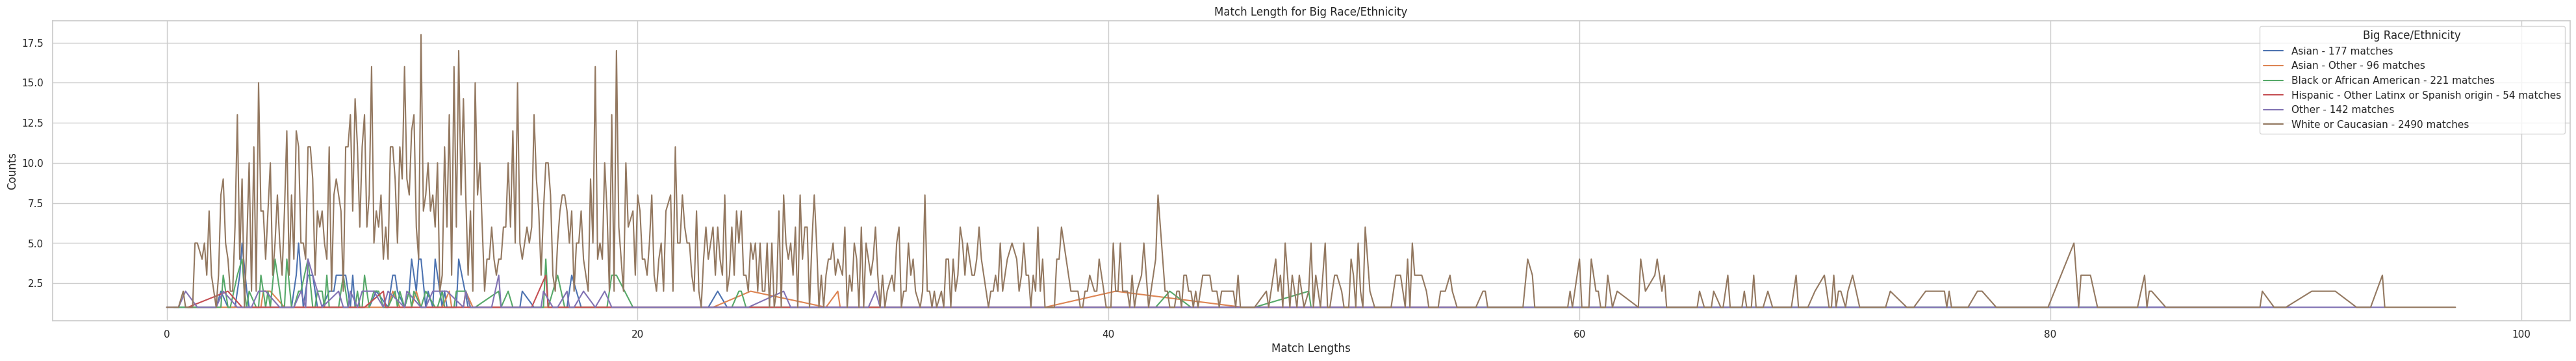

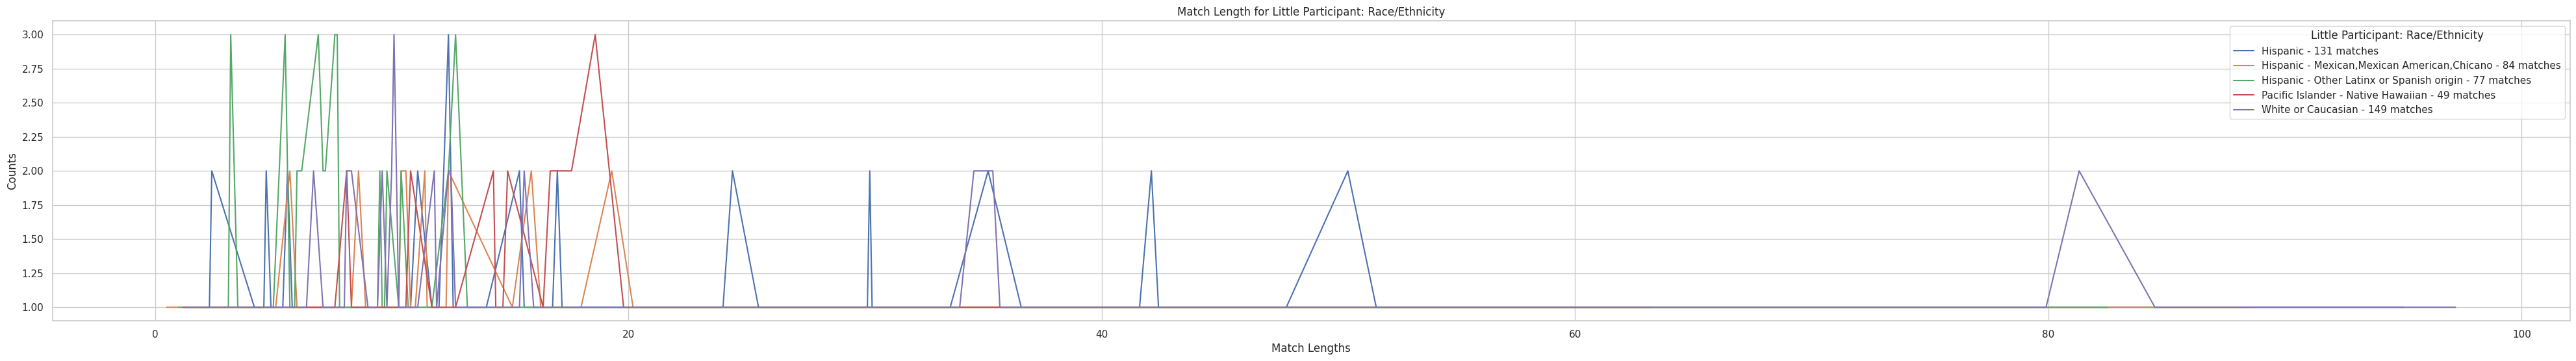

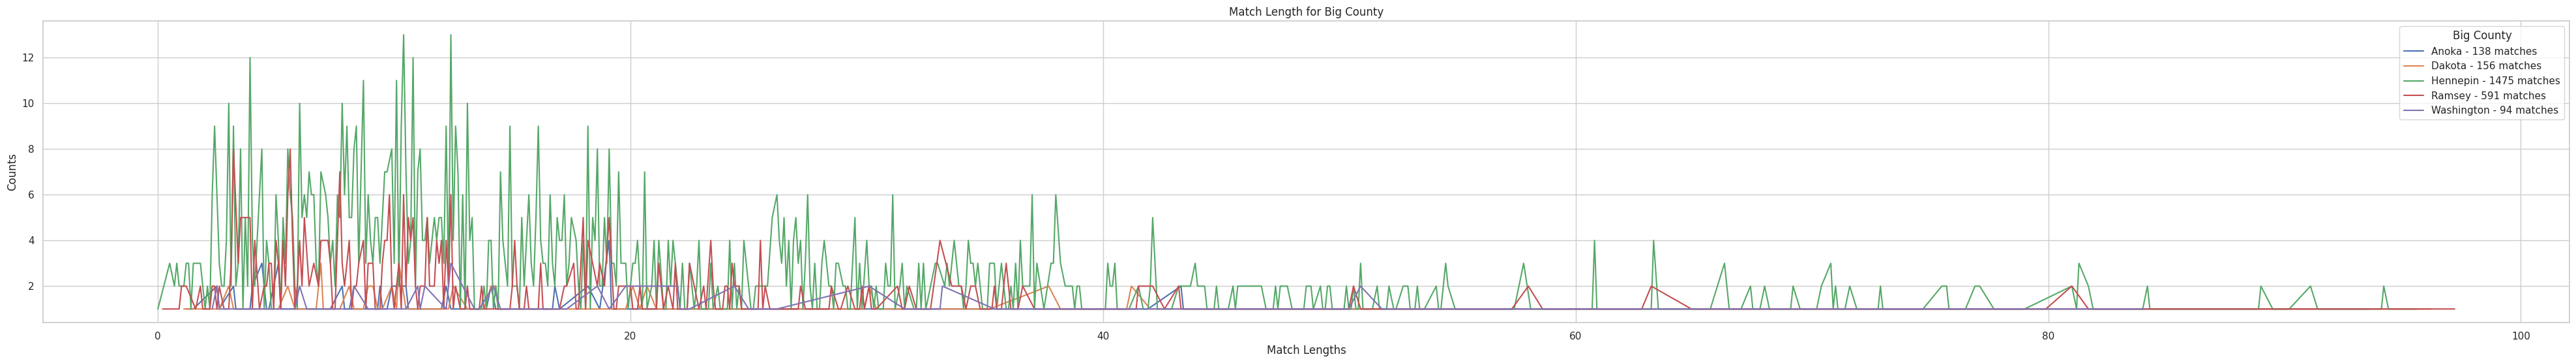

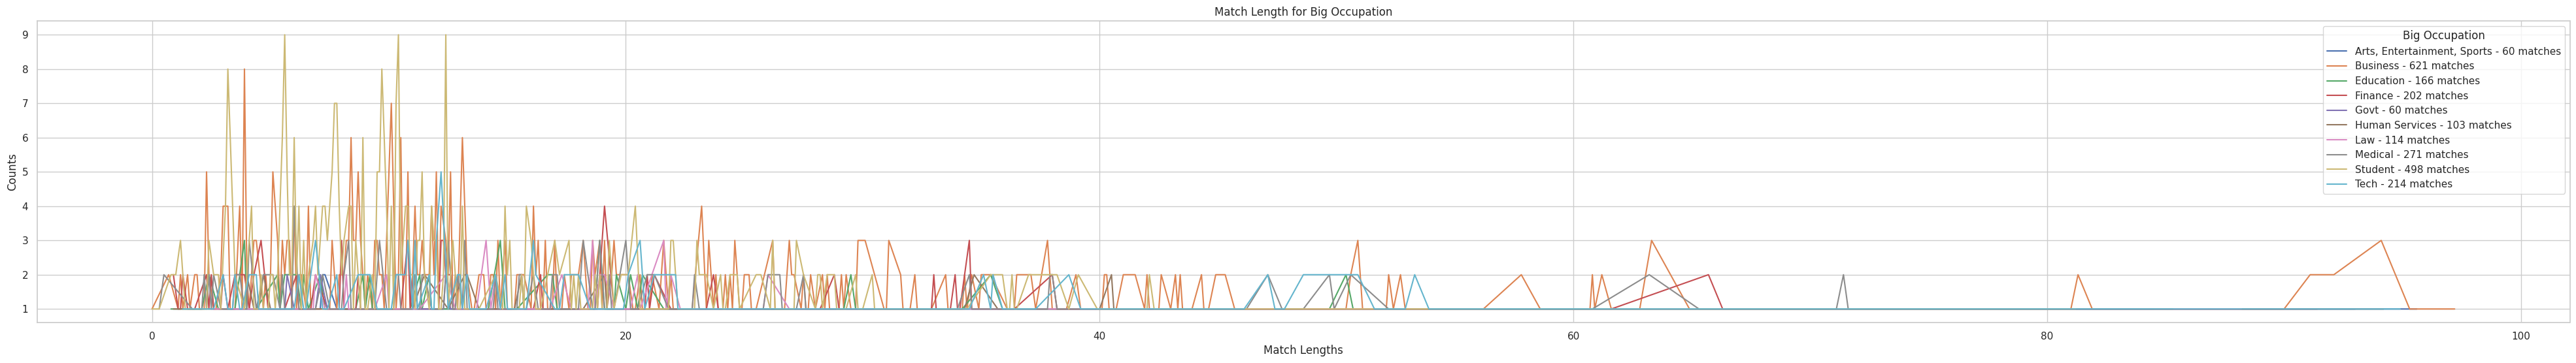

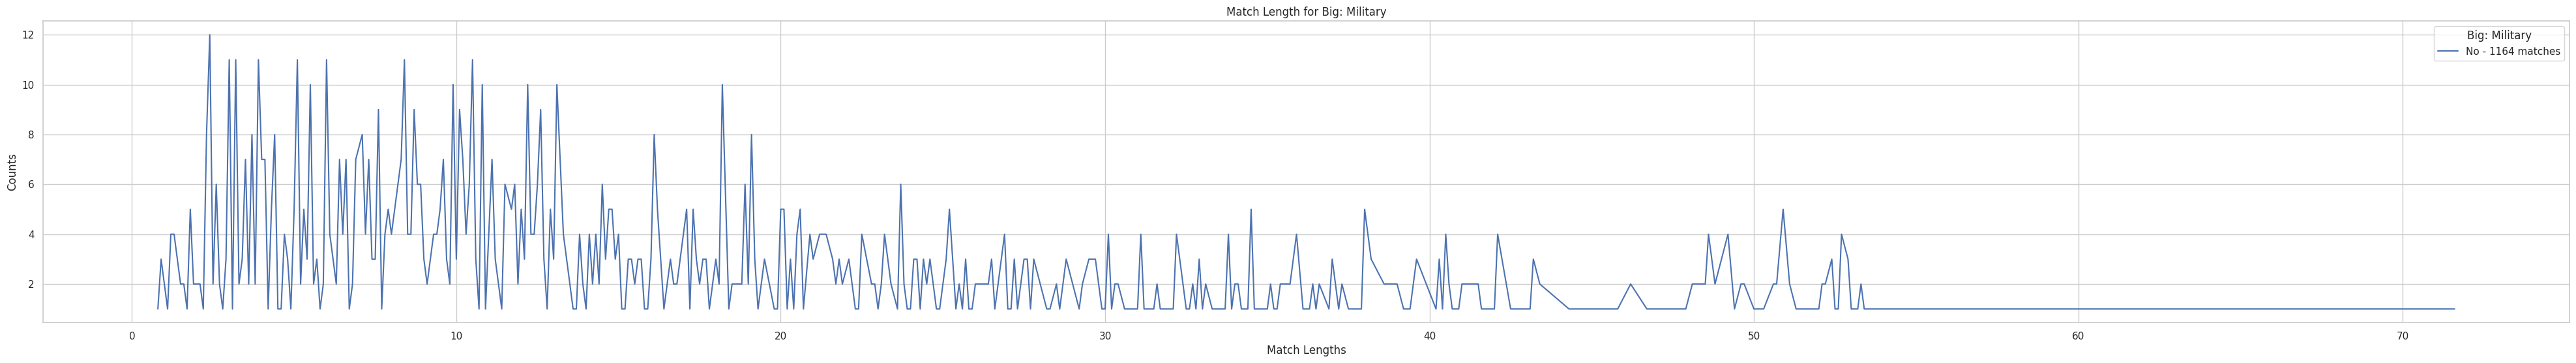

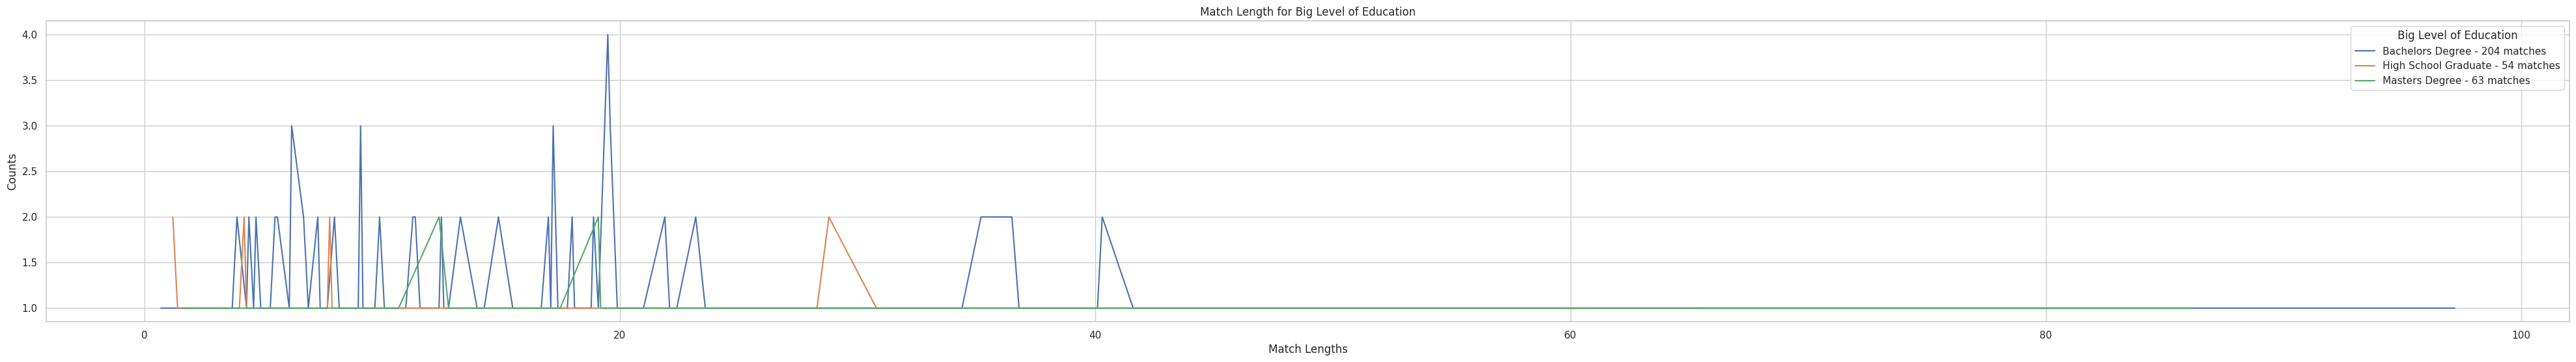

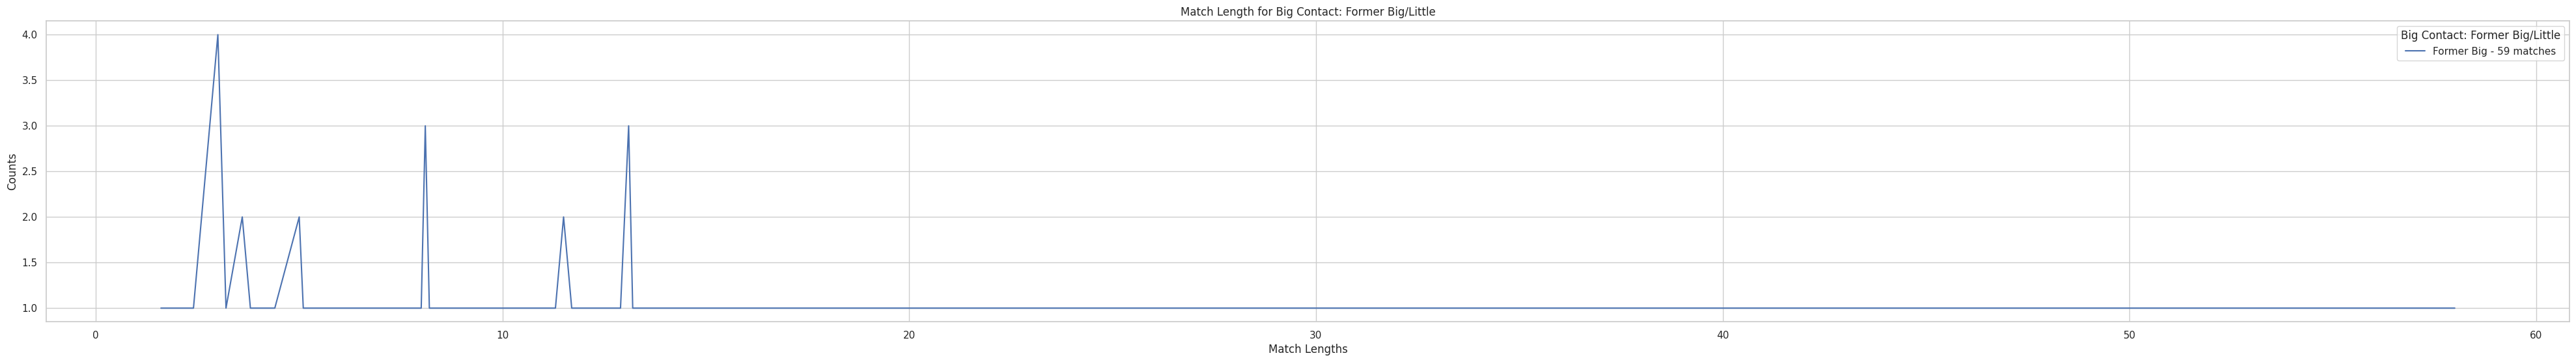

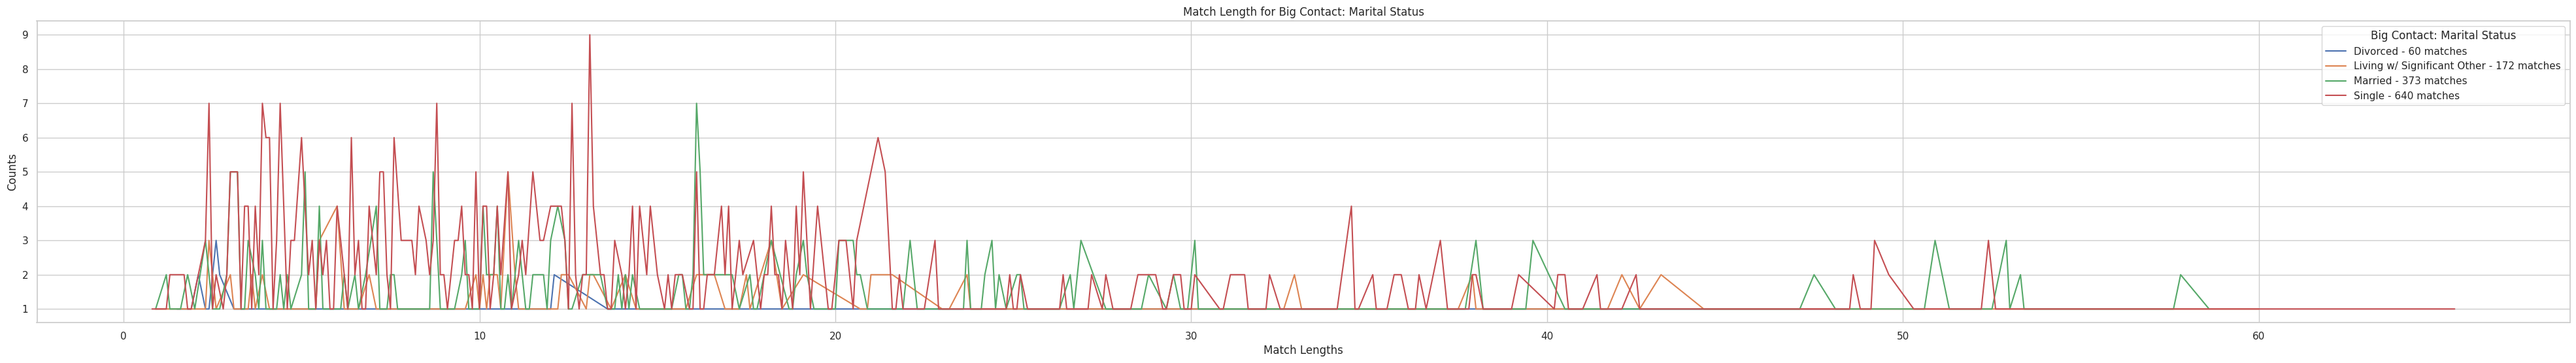

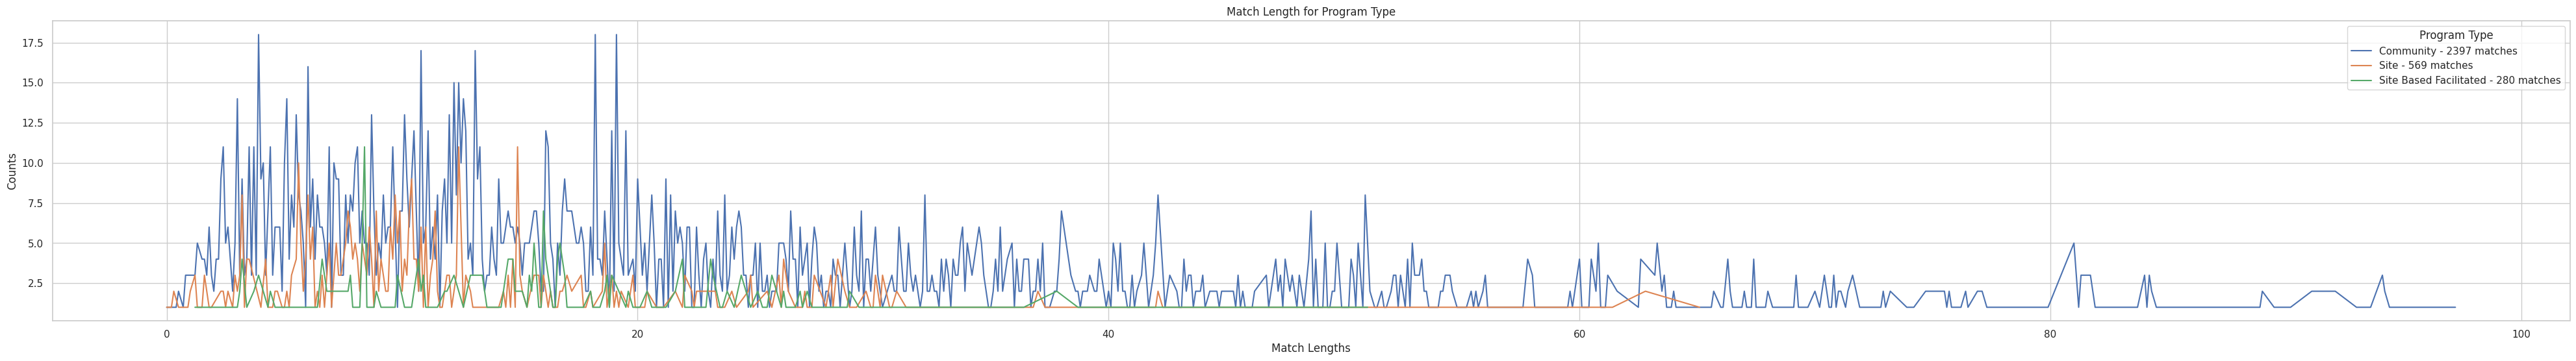

In [178]:
# Set the style of seaborn
sns.set(style="whitegrid")

# Iterate over each category and its values
dem_cats = categorical_cols['one-hot']
for cat, vals in dem_cats.items():
    plt.figure(figsize=(50, 6))
    plt.title(f"Match Length for {cat}")
    plt.xlabel("Match Lengths")
    plt.ylabel("Counts")

    # Plot each one-hot encoded column within the category
    for val in vals:
        if val == 'Unknown':
            continue
        col_name = f"{cat}{subcategory_delimiter}{val}"
        if col_name in df_high_count.columns:
            df_ingroup = df_high_count[df_high_count[col_name] == 1]
            # Calculate the frequency of each unique Match Length value
            match_length_counts = df_ingroup['Match Length'].value_counts().sort_index()
            sns.lineplot(x=match_length_counts.index, y=match_length_counts.values, label=f"{val} - {len(df_ingroup)} matches")

    plt.legend(title=cat)
    plt.show()


In [179]:
!pip install lifelines

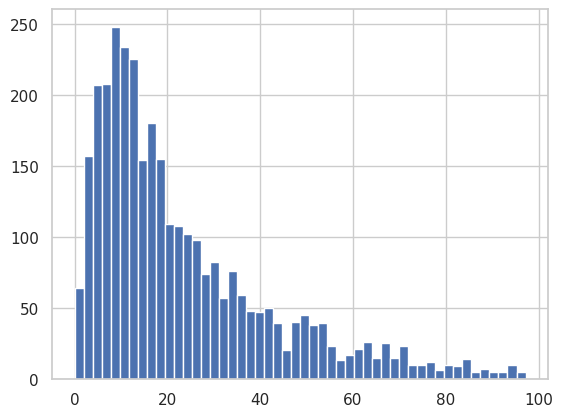

In [180]:
import numpy as np
import pandas as pd
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# print(df_high_count.shape)
# print(df_high_count.dtypes)
# print(df_high_count.isnull().sum().to_markdown())

T = df_high_count["Match Length"]
E = df_high_count["Stage"]
plt.hist(T, bins = 50)
plt.show()


In [181]:
print(df_high_count.dtypes.to_markdown())

|                                                                                   | 0       |
|:----------------------------------------------------------------------------------|:--------|
| Stage                                                                             | object  |
| Closure Reason                                                                    | object  |
| Match Length                                                                      | float64 |
| Big Age                                                                           | int64   |
| Big Gender                                                                        | object  |
| Big Race/Ethnicity >> Asian                                                       | int64   |
| Big Race/Ethnicity >> Asian - Other                                               | int64   |
| Big Race/Ethnicity >> Black or African American                                   | int64   |
| Big Race/Ethnicity >> Hispanic - Other

/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<Axes: xlabel='timeline'>

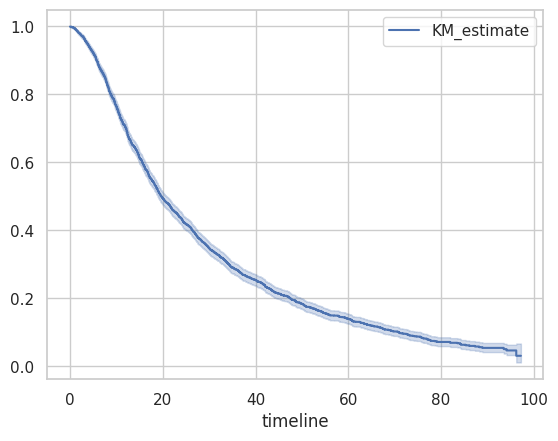

In [182]:
kmf = KaplanMeierFitter()
kmf.fit(durations = T, event_observed = E)
kmf.plot_survival_function()

In [183]:
from lifelines.utils import median_survival_times
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print(median_)
print(median_confidence_interval_)

19.8
     KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5                    18.9                    20.8


/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/utils

<Figure size 1200x1200 with 0 Axes>

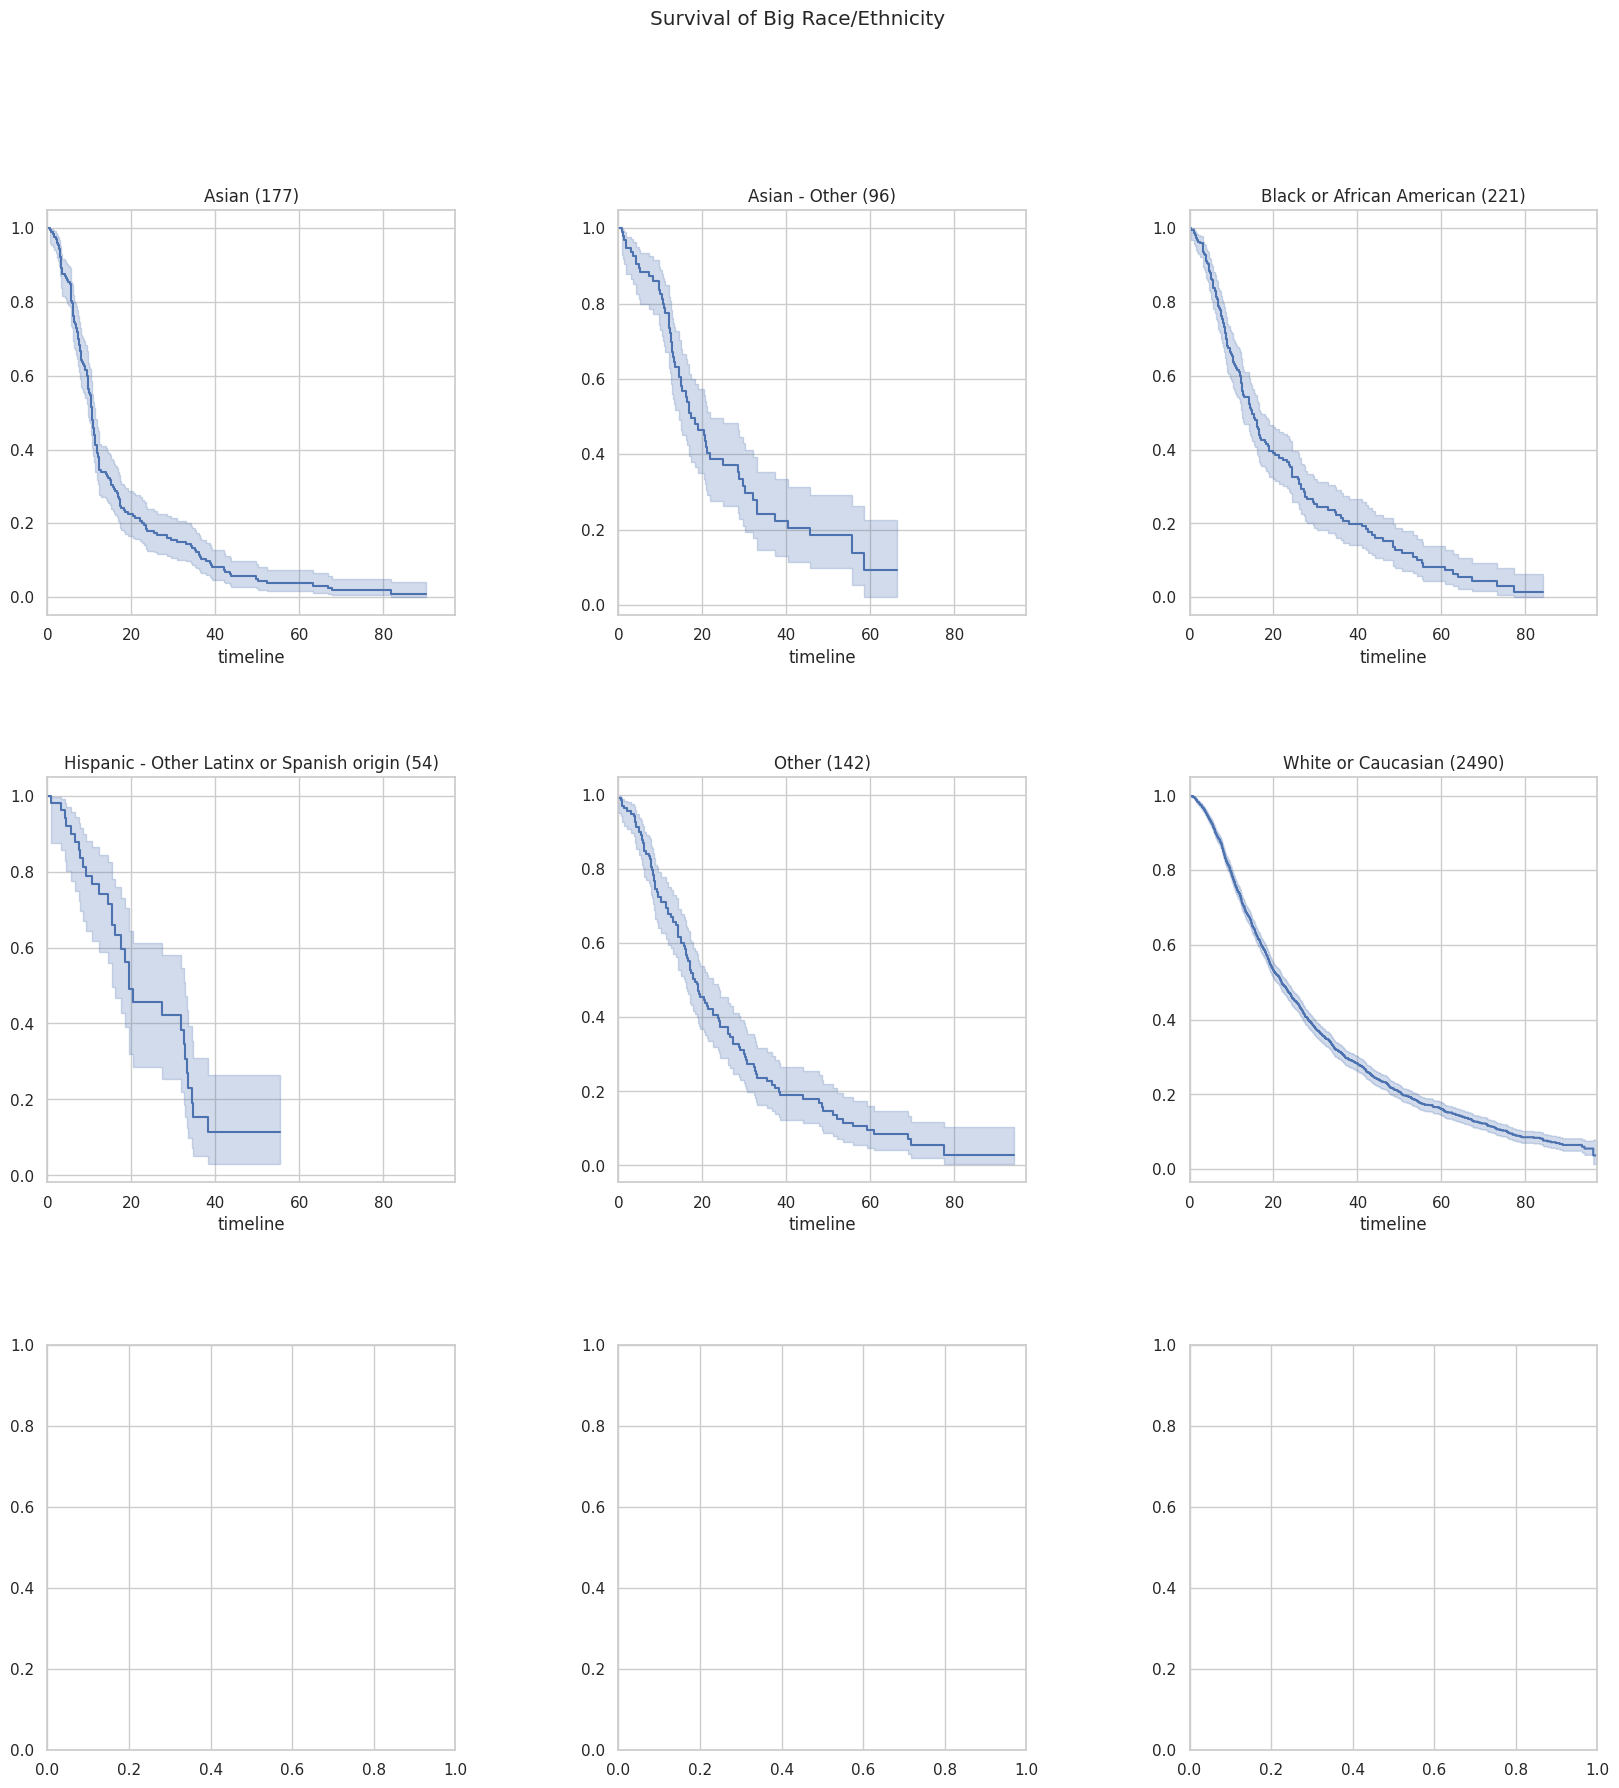

/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/utils

<Figure size 1200x1200 with 0 Axes>

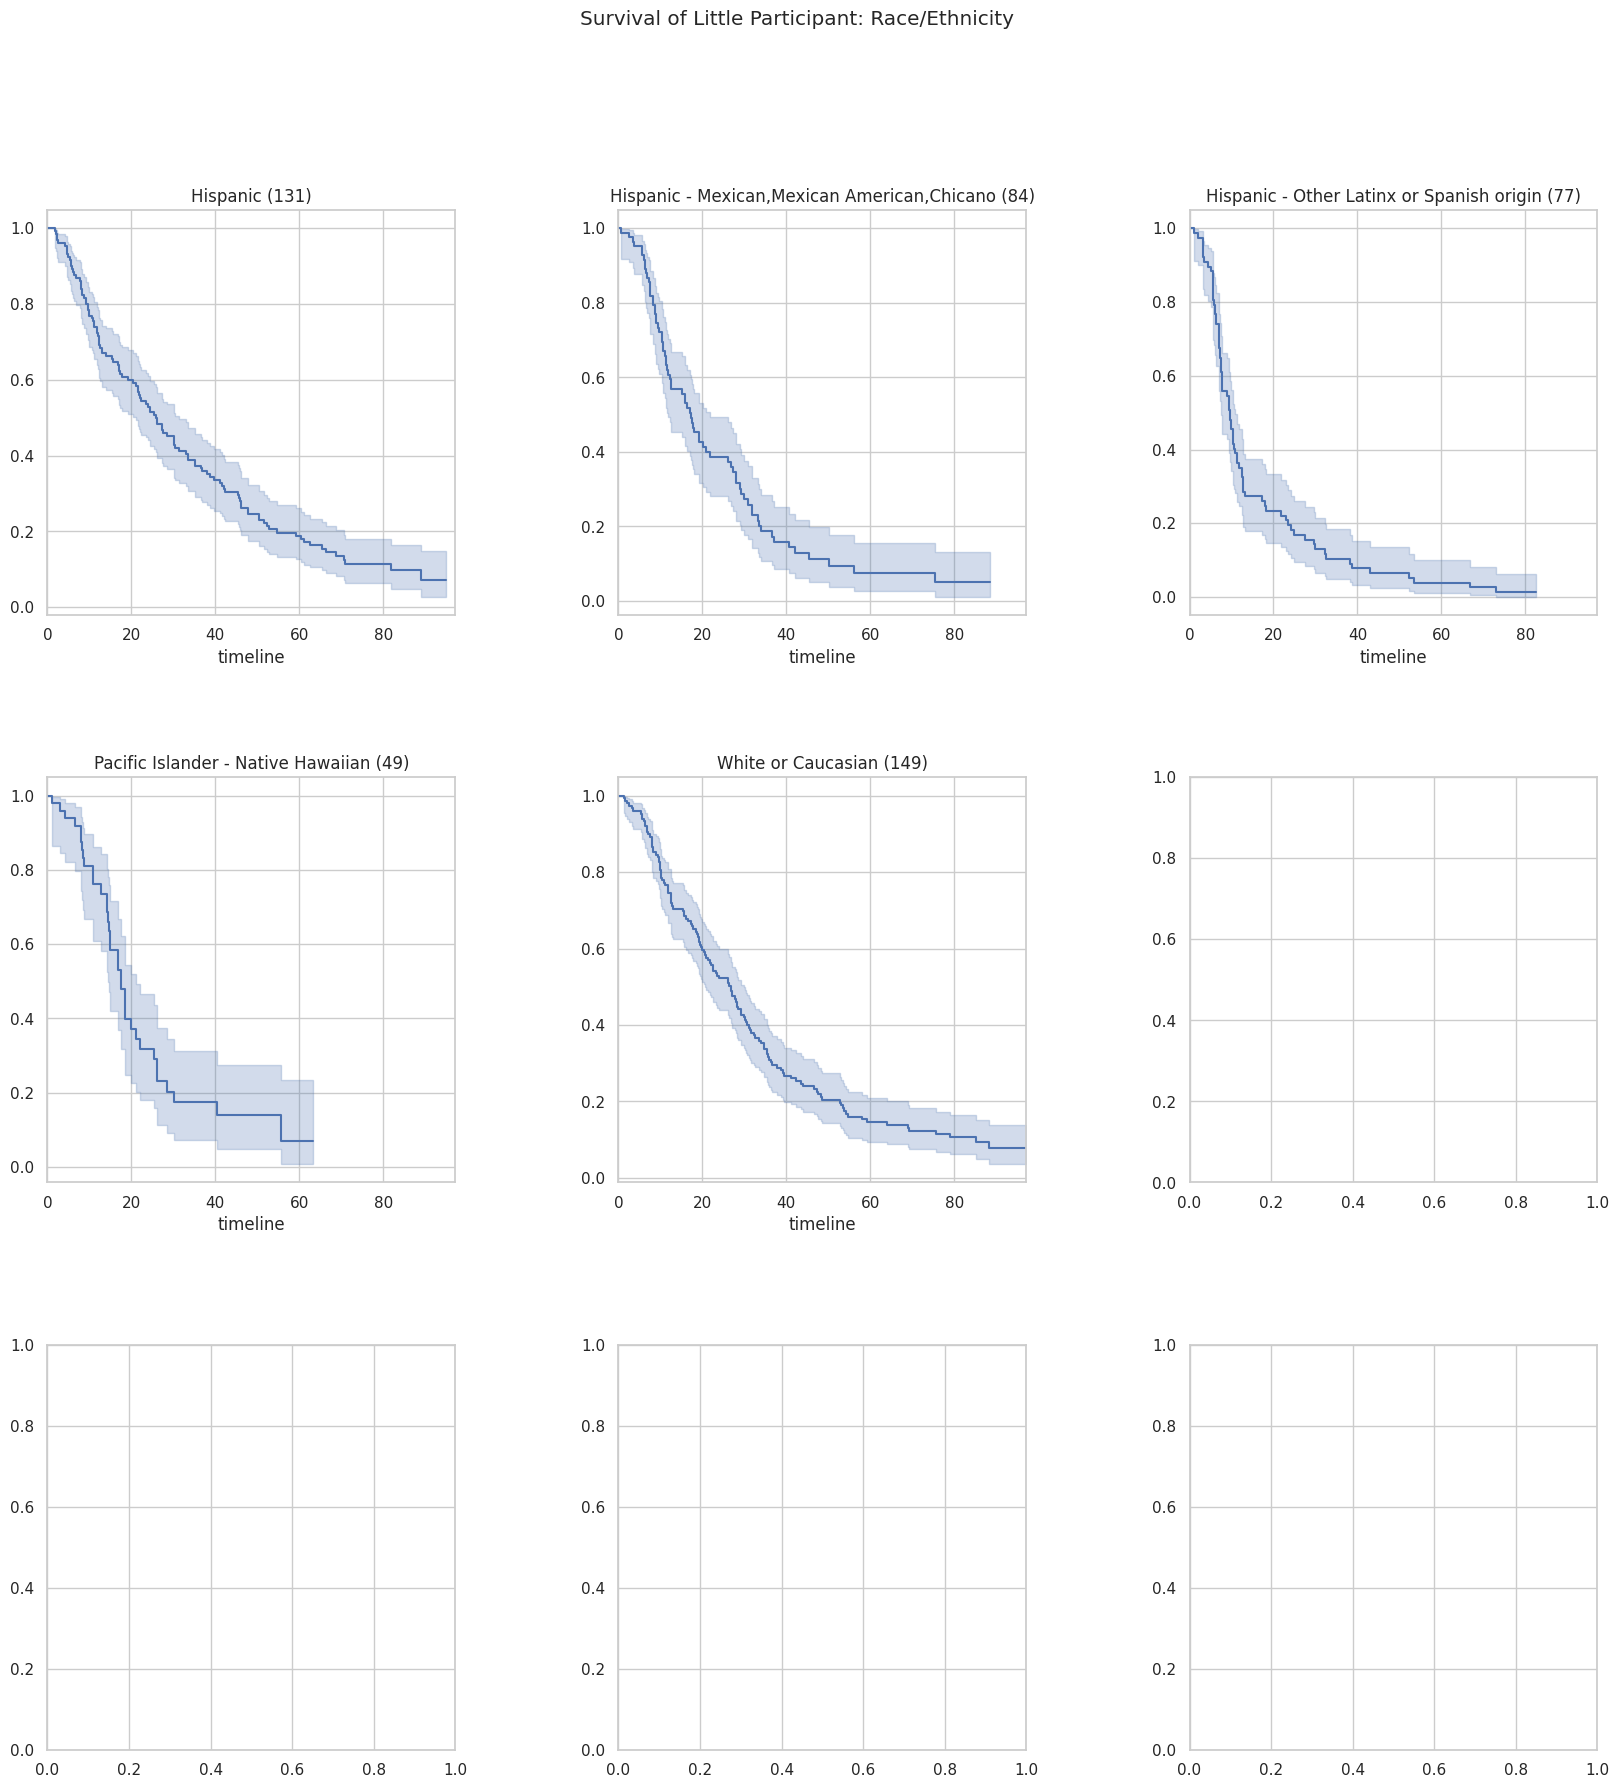

/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/utils

<Figure size 1200x1200 with 0 Axes>

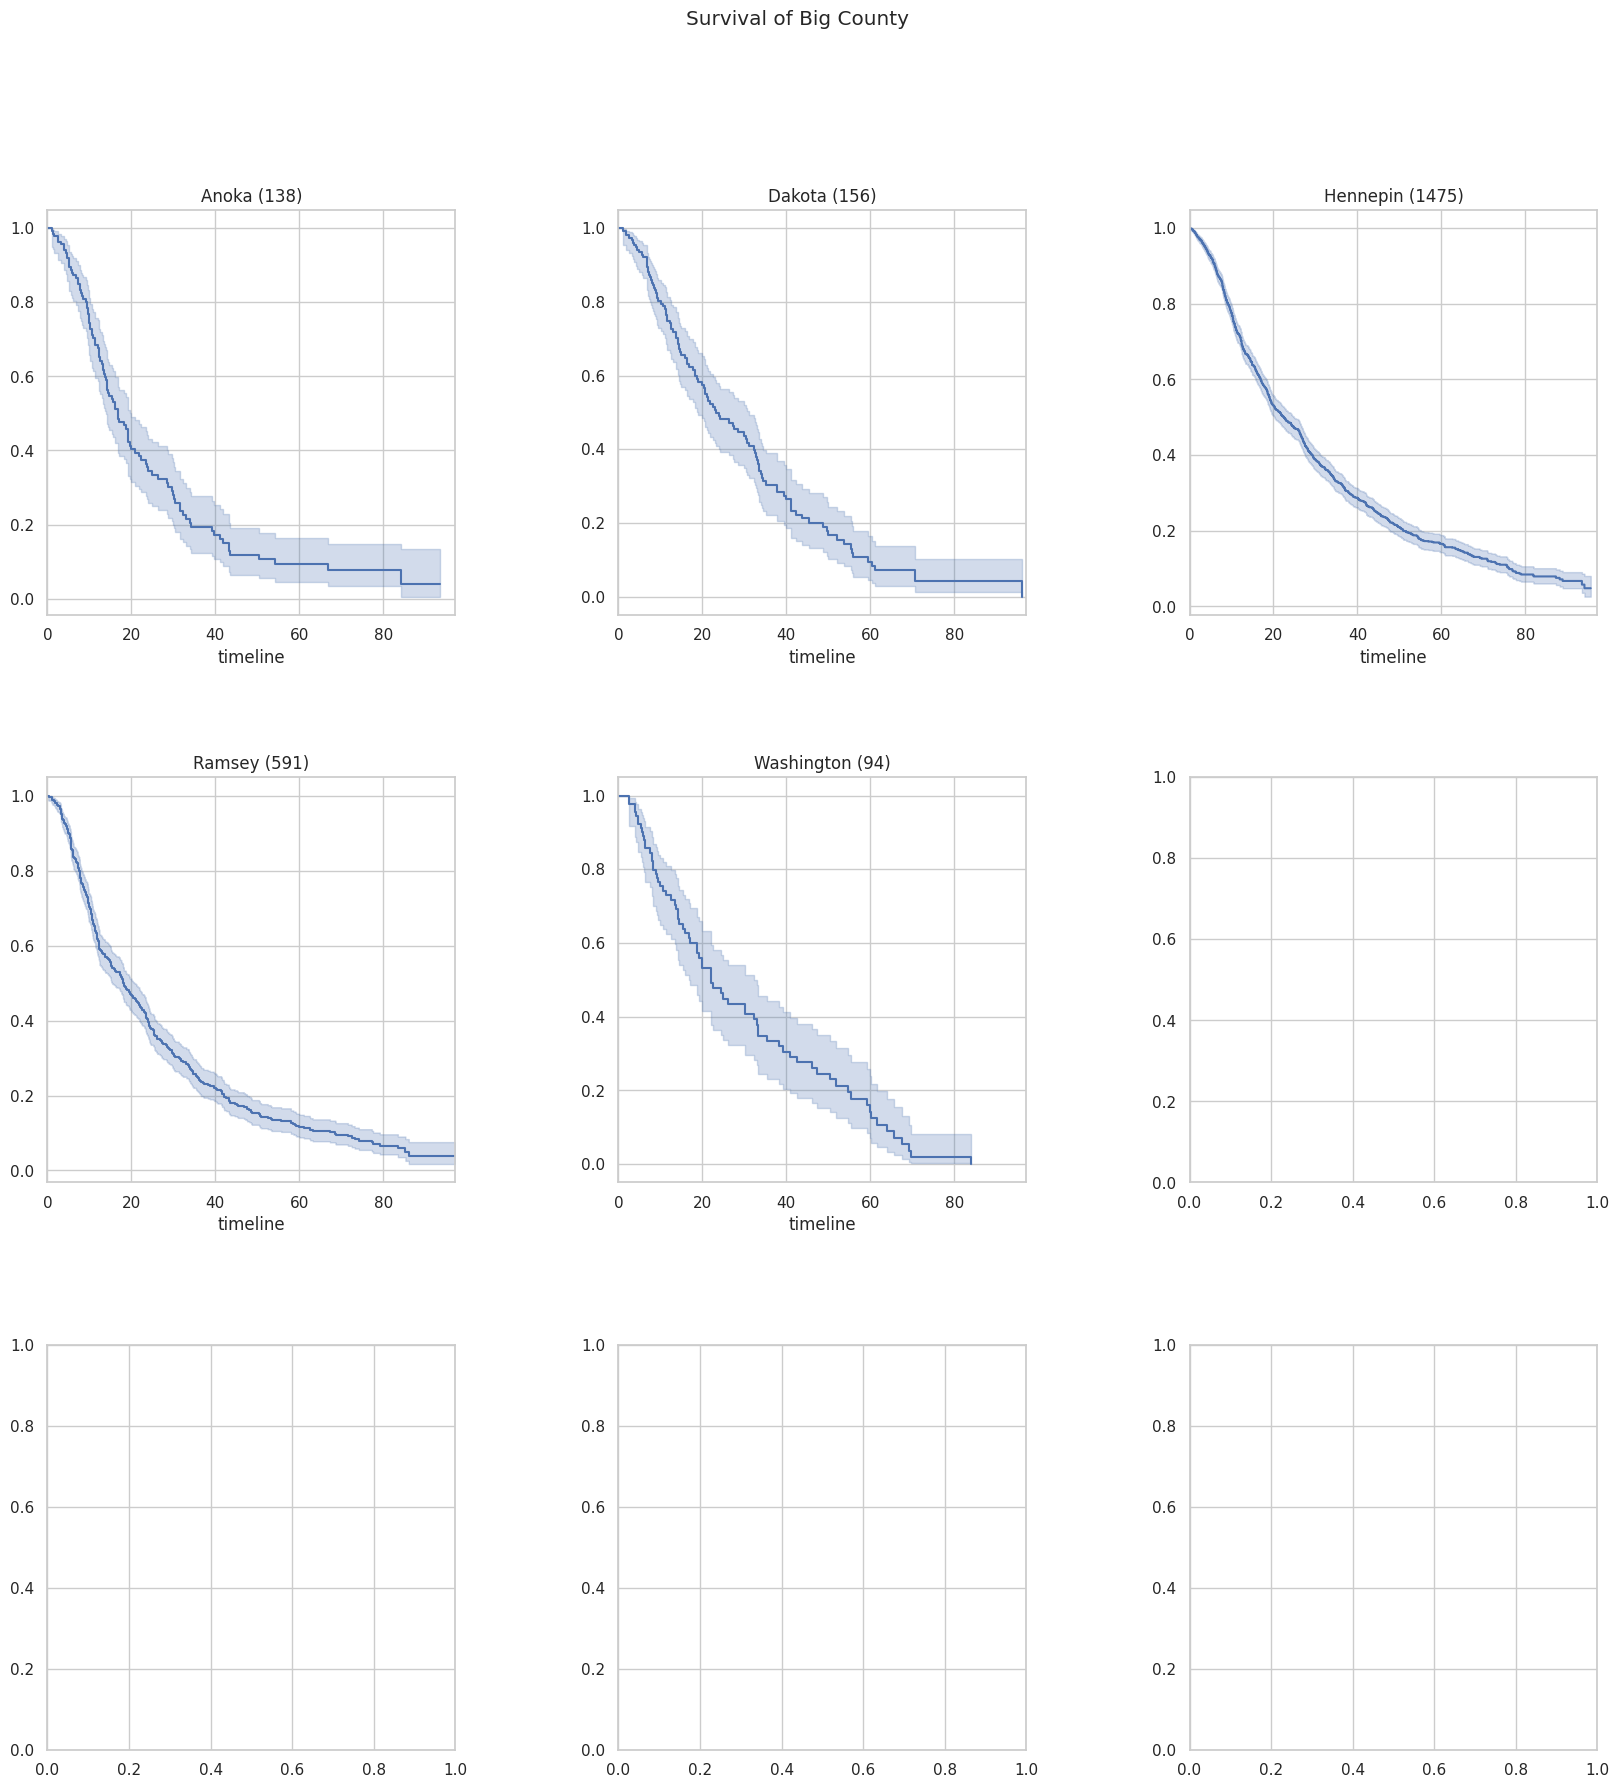

/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/utils

<Figure size 1600x1600 with 0 Axes>

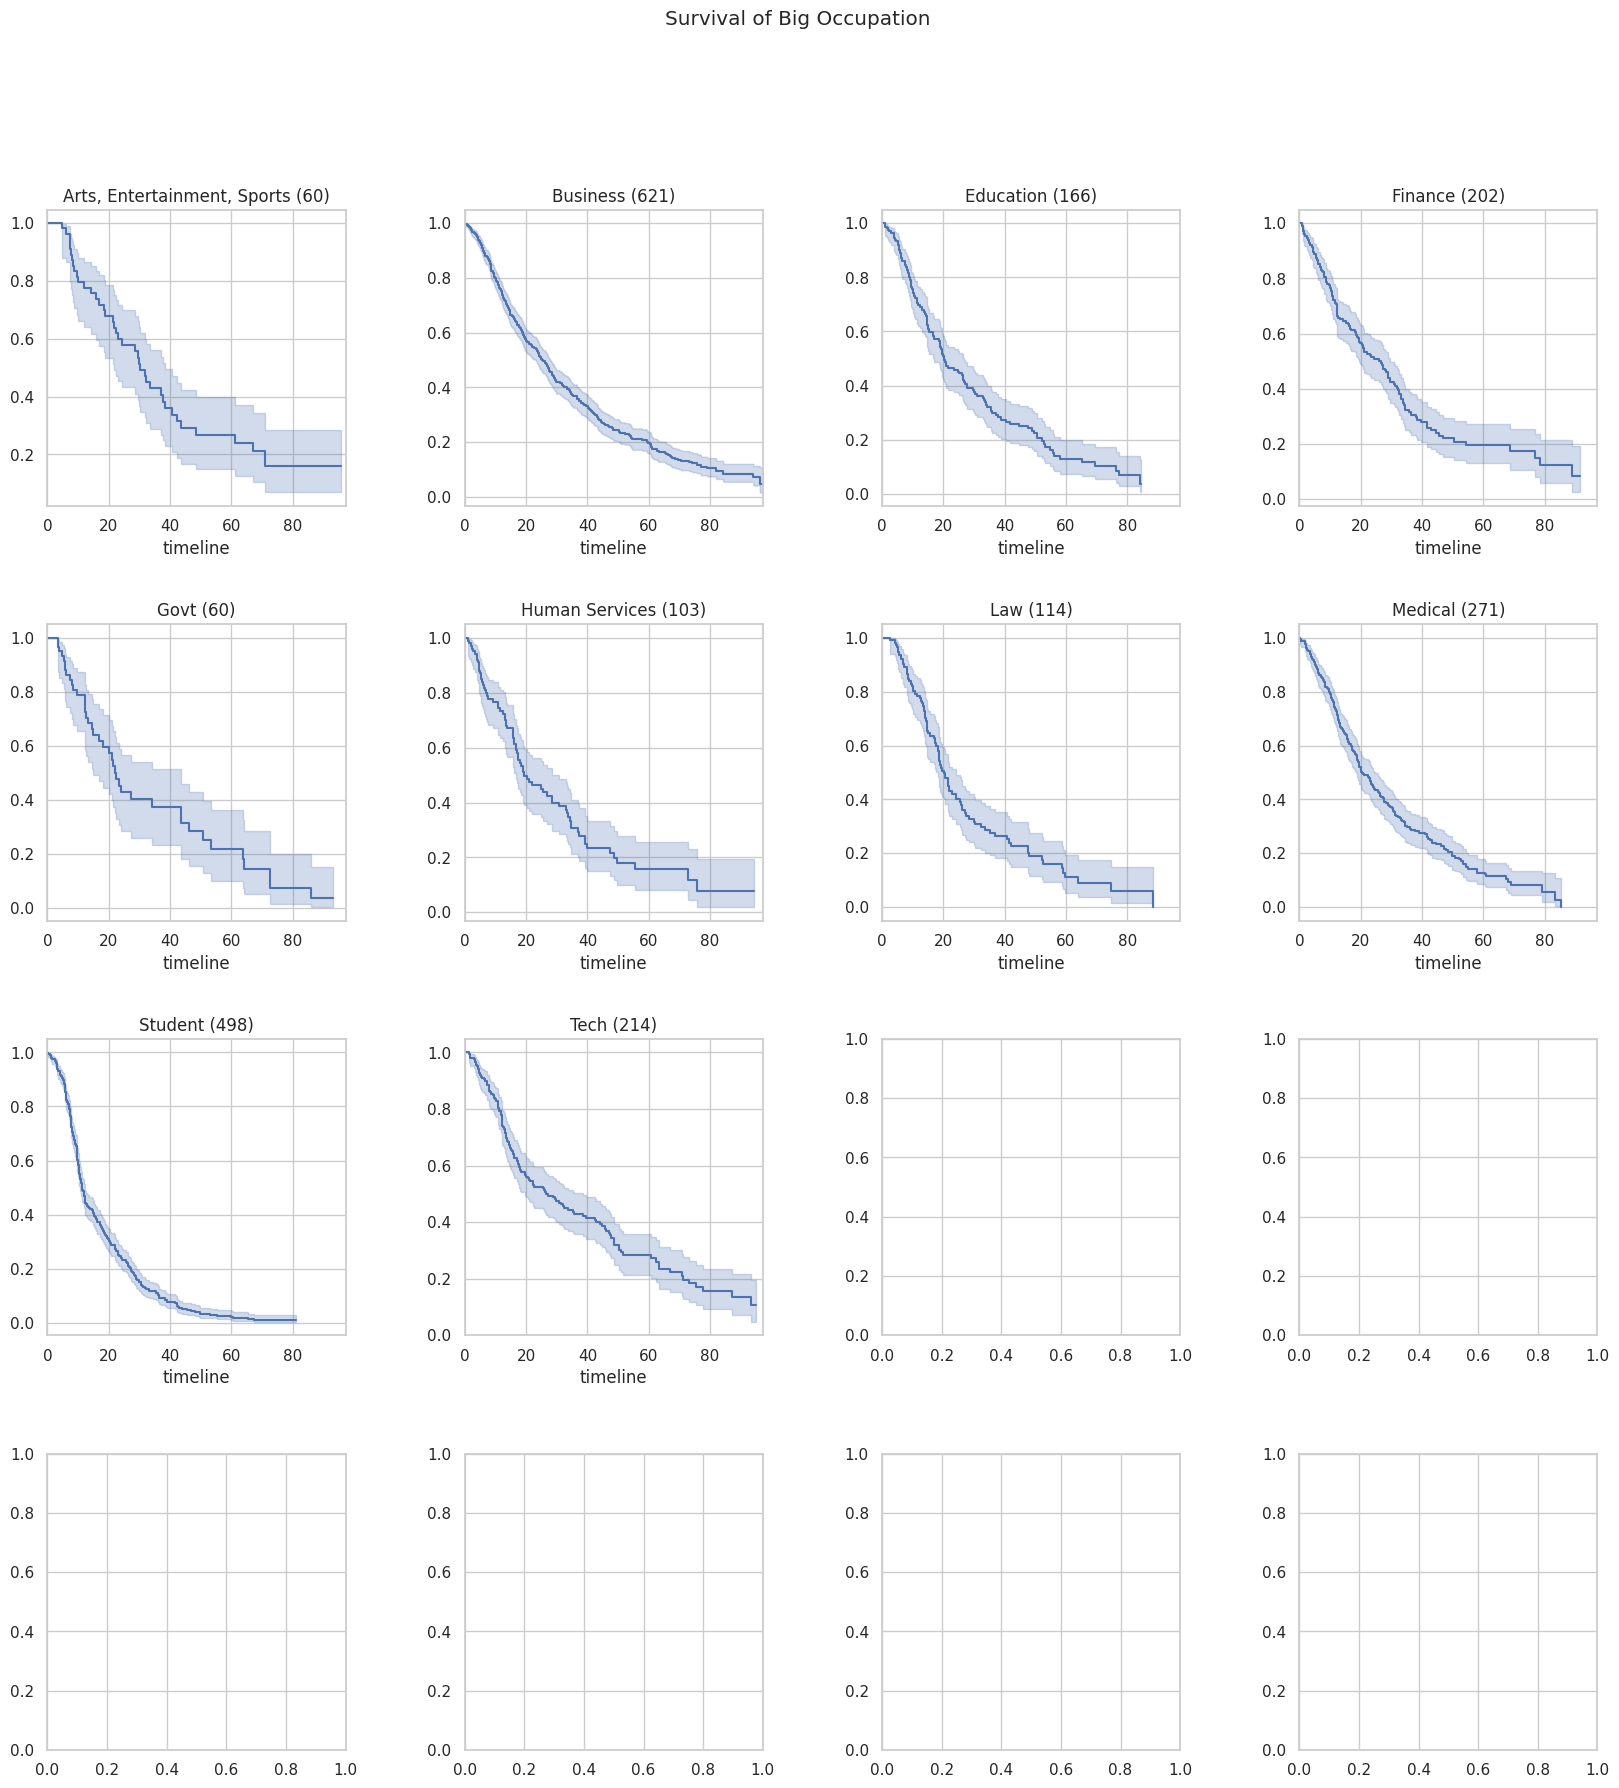

/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<Figure size 400x400 with 0 Axes>

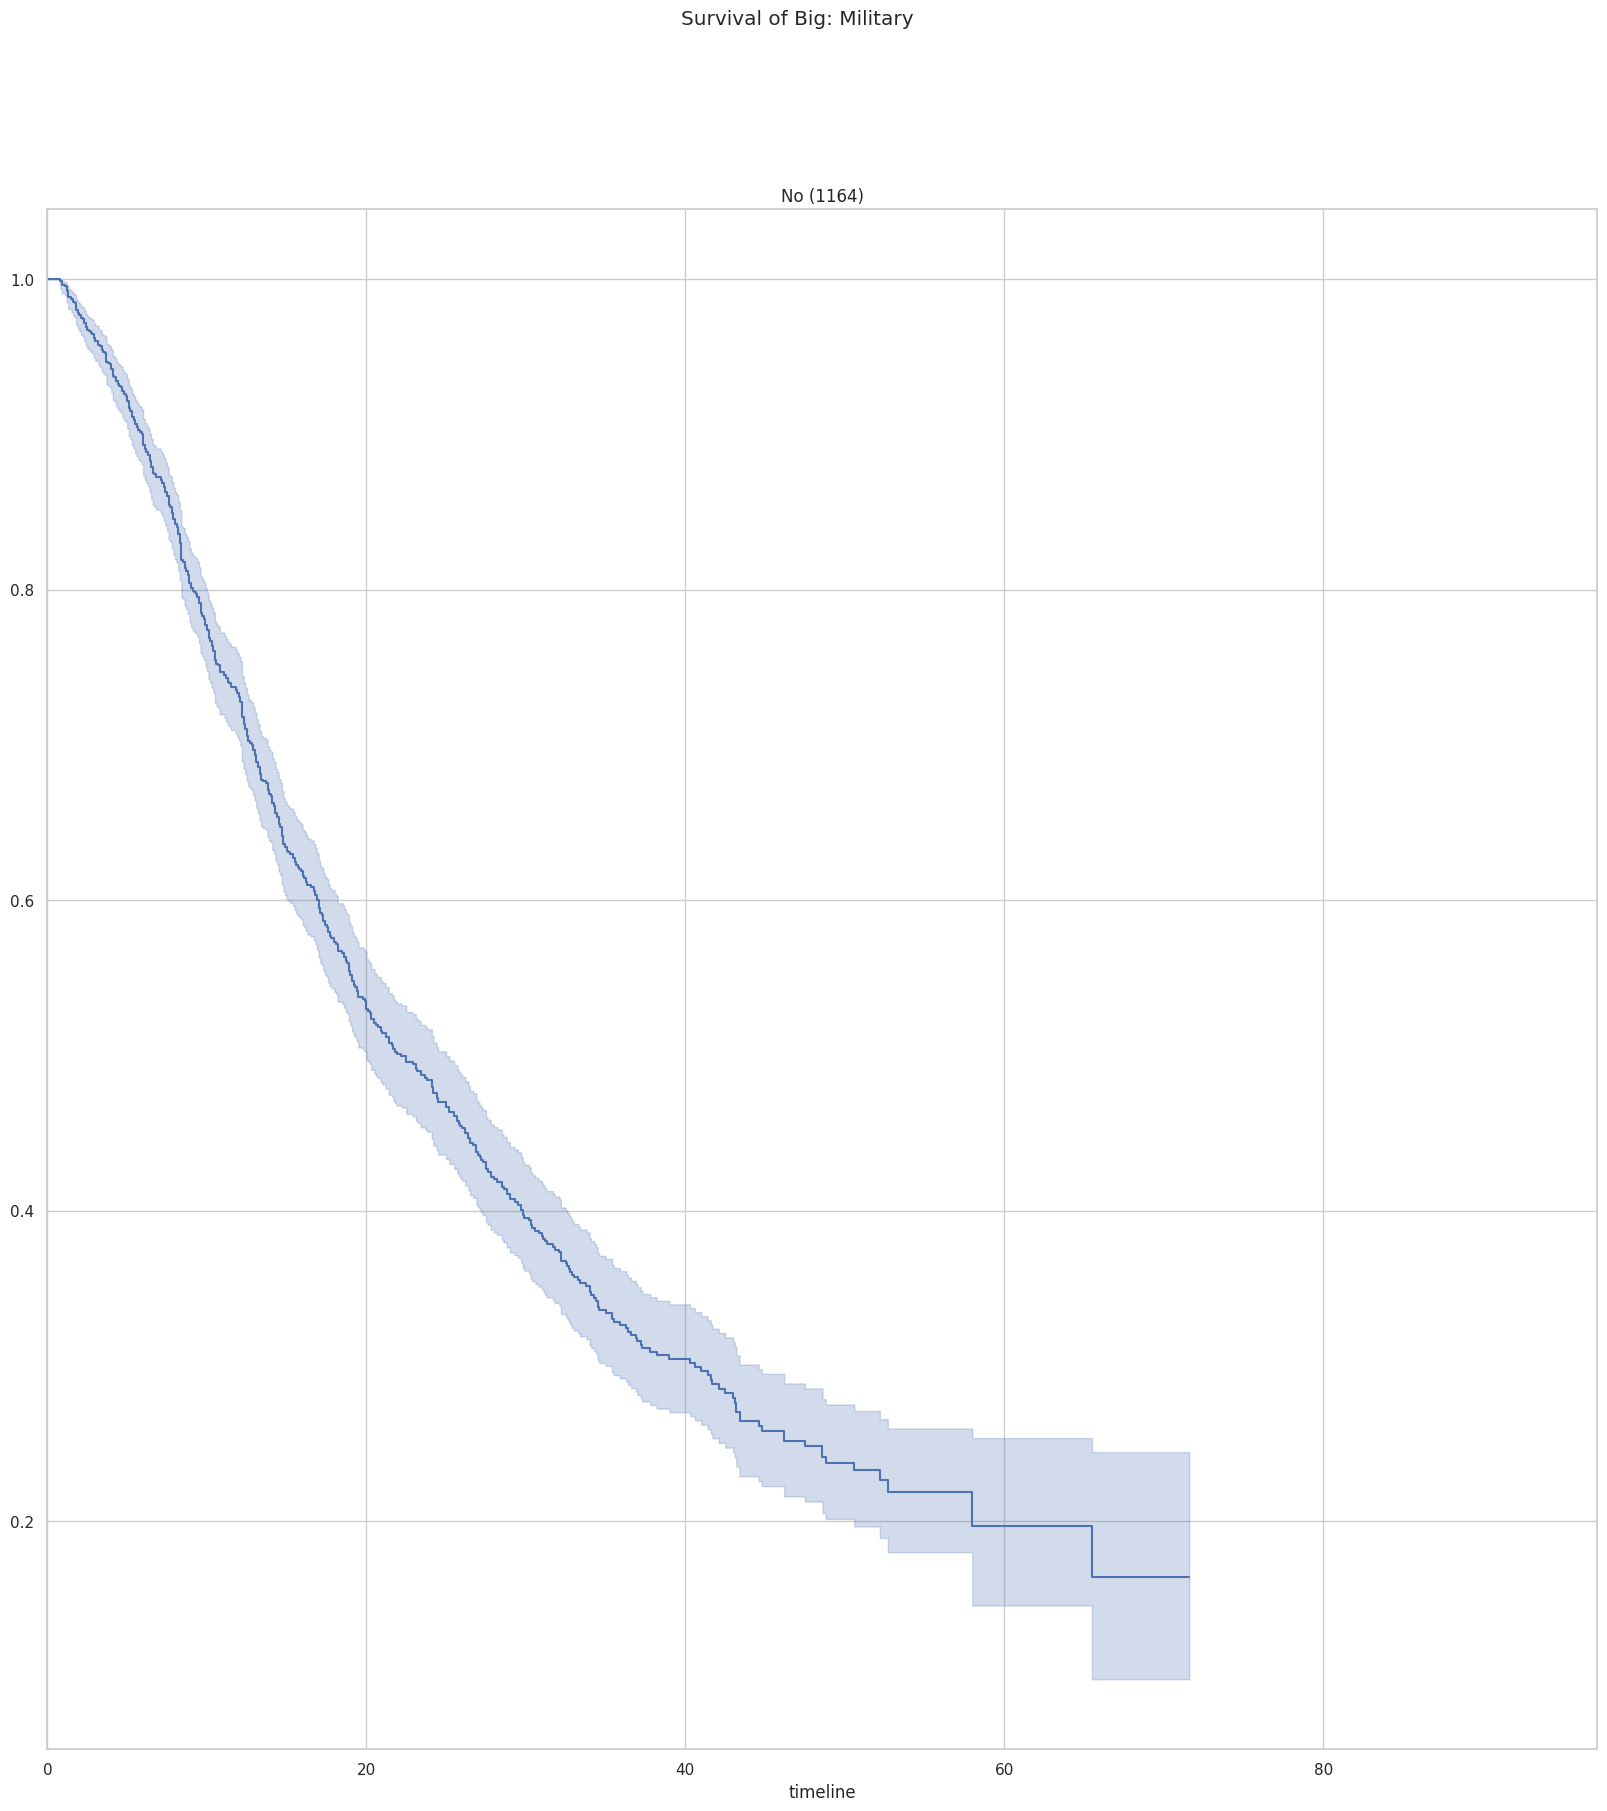

/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<Figure size 800x800 with 0 Axes>

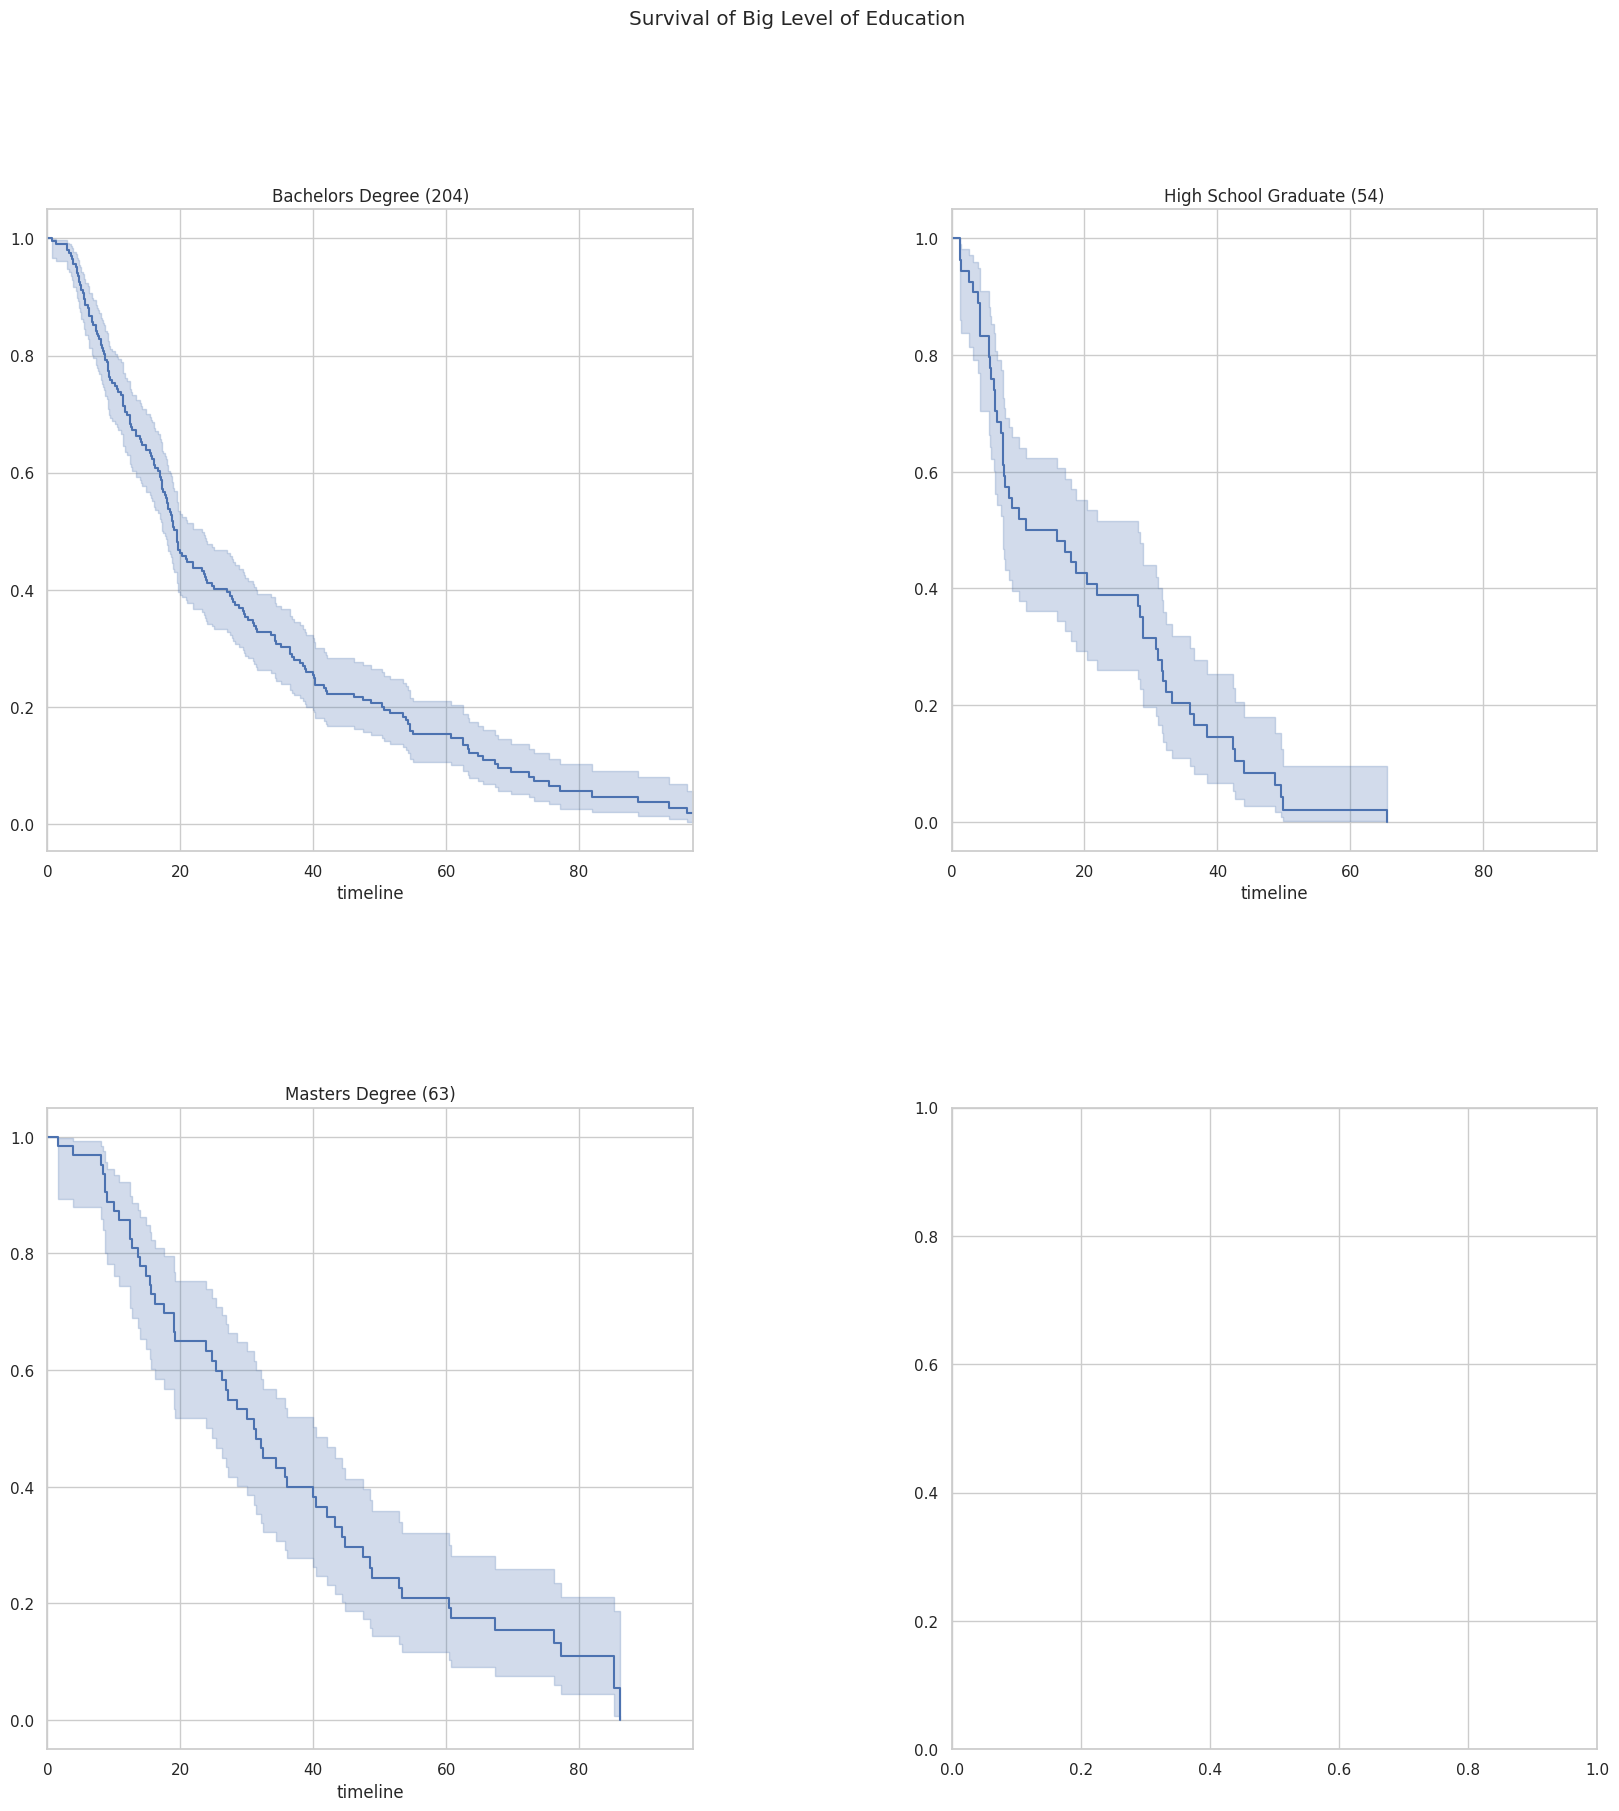

/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<Figure size 400x400 with 0 Axes>

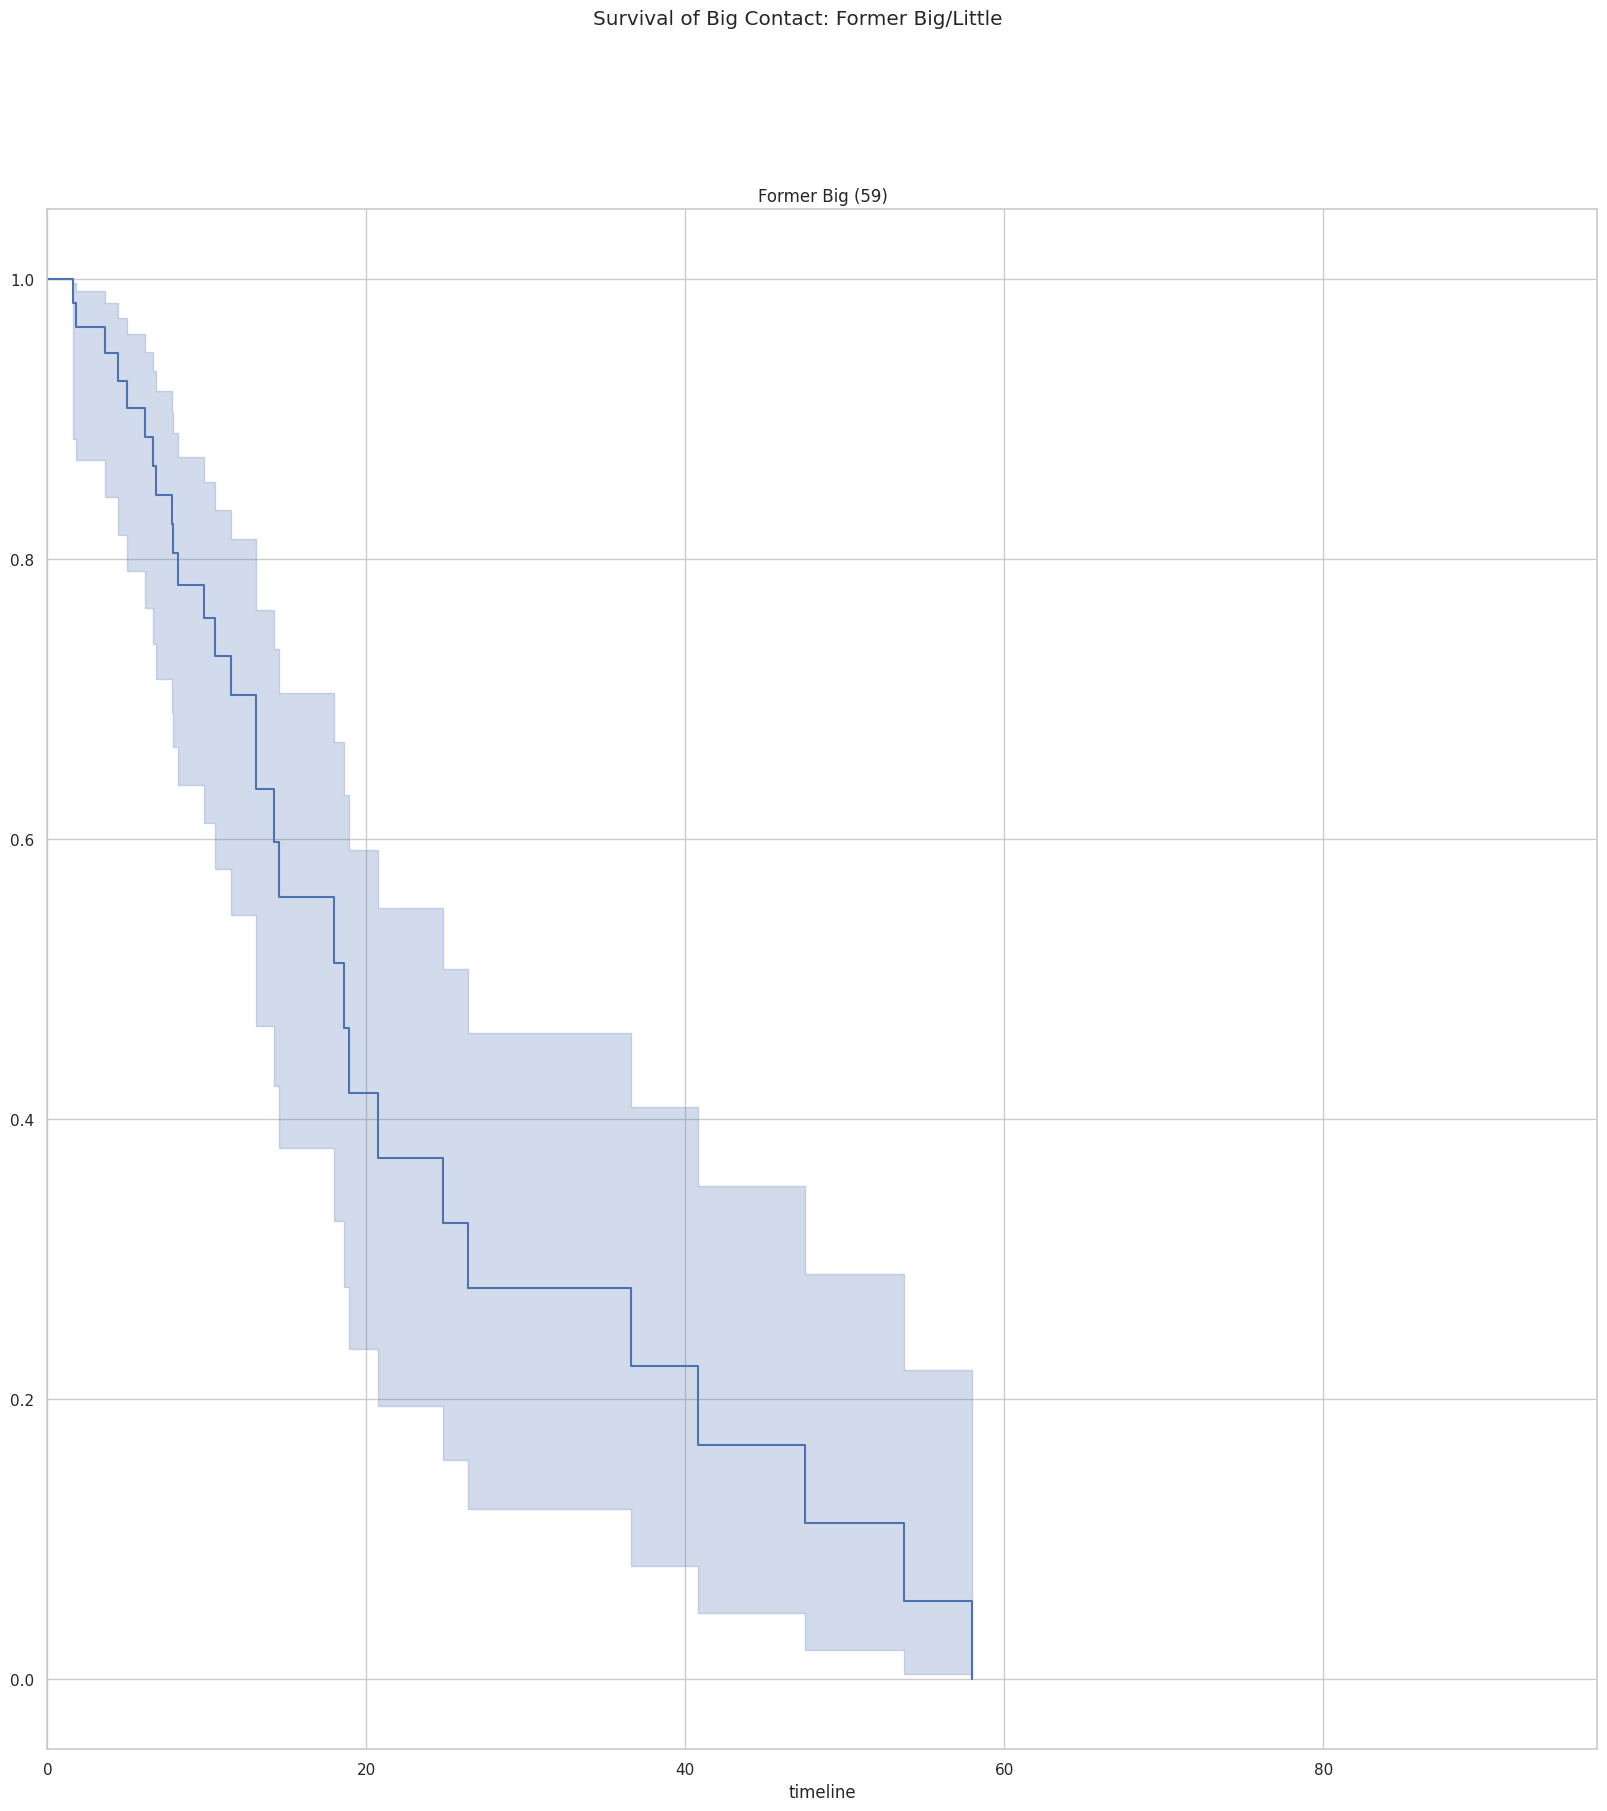

/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/utils

<Figure size 800x800 with 0 Axes>

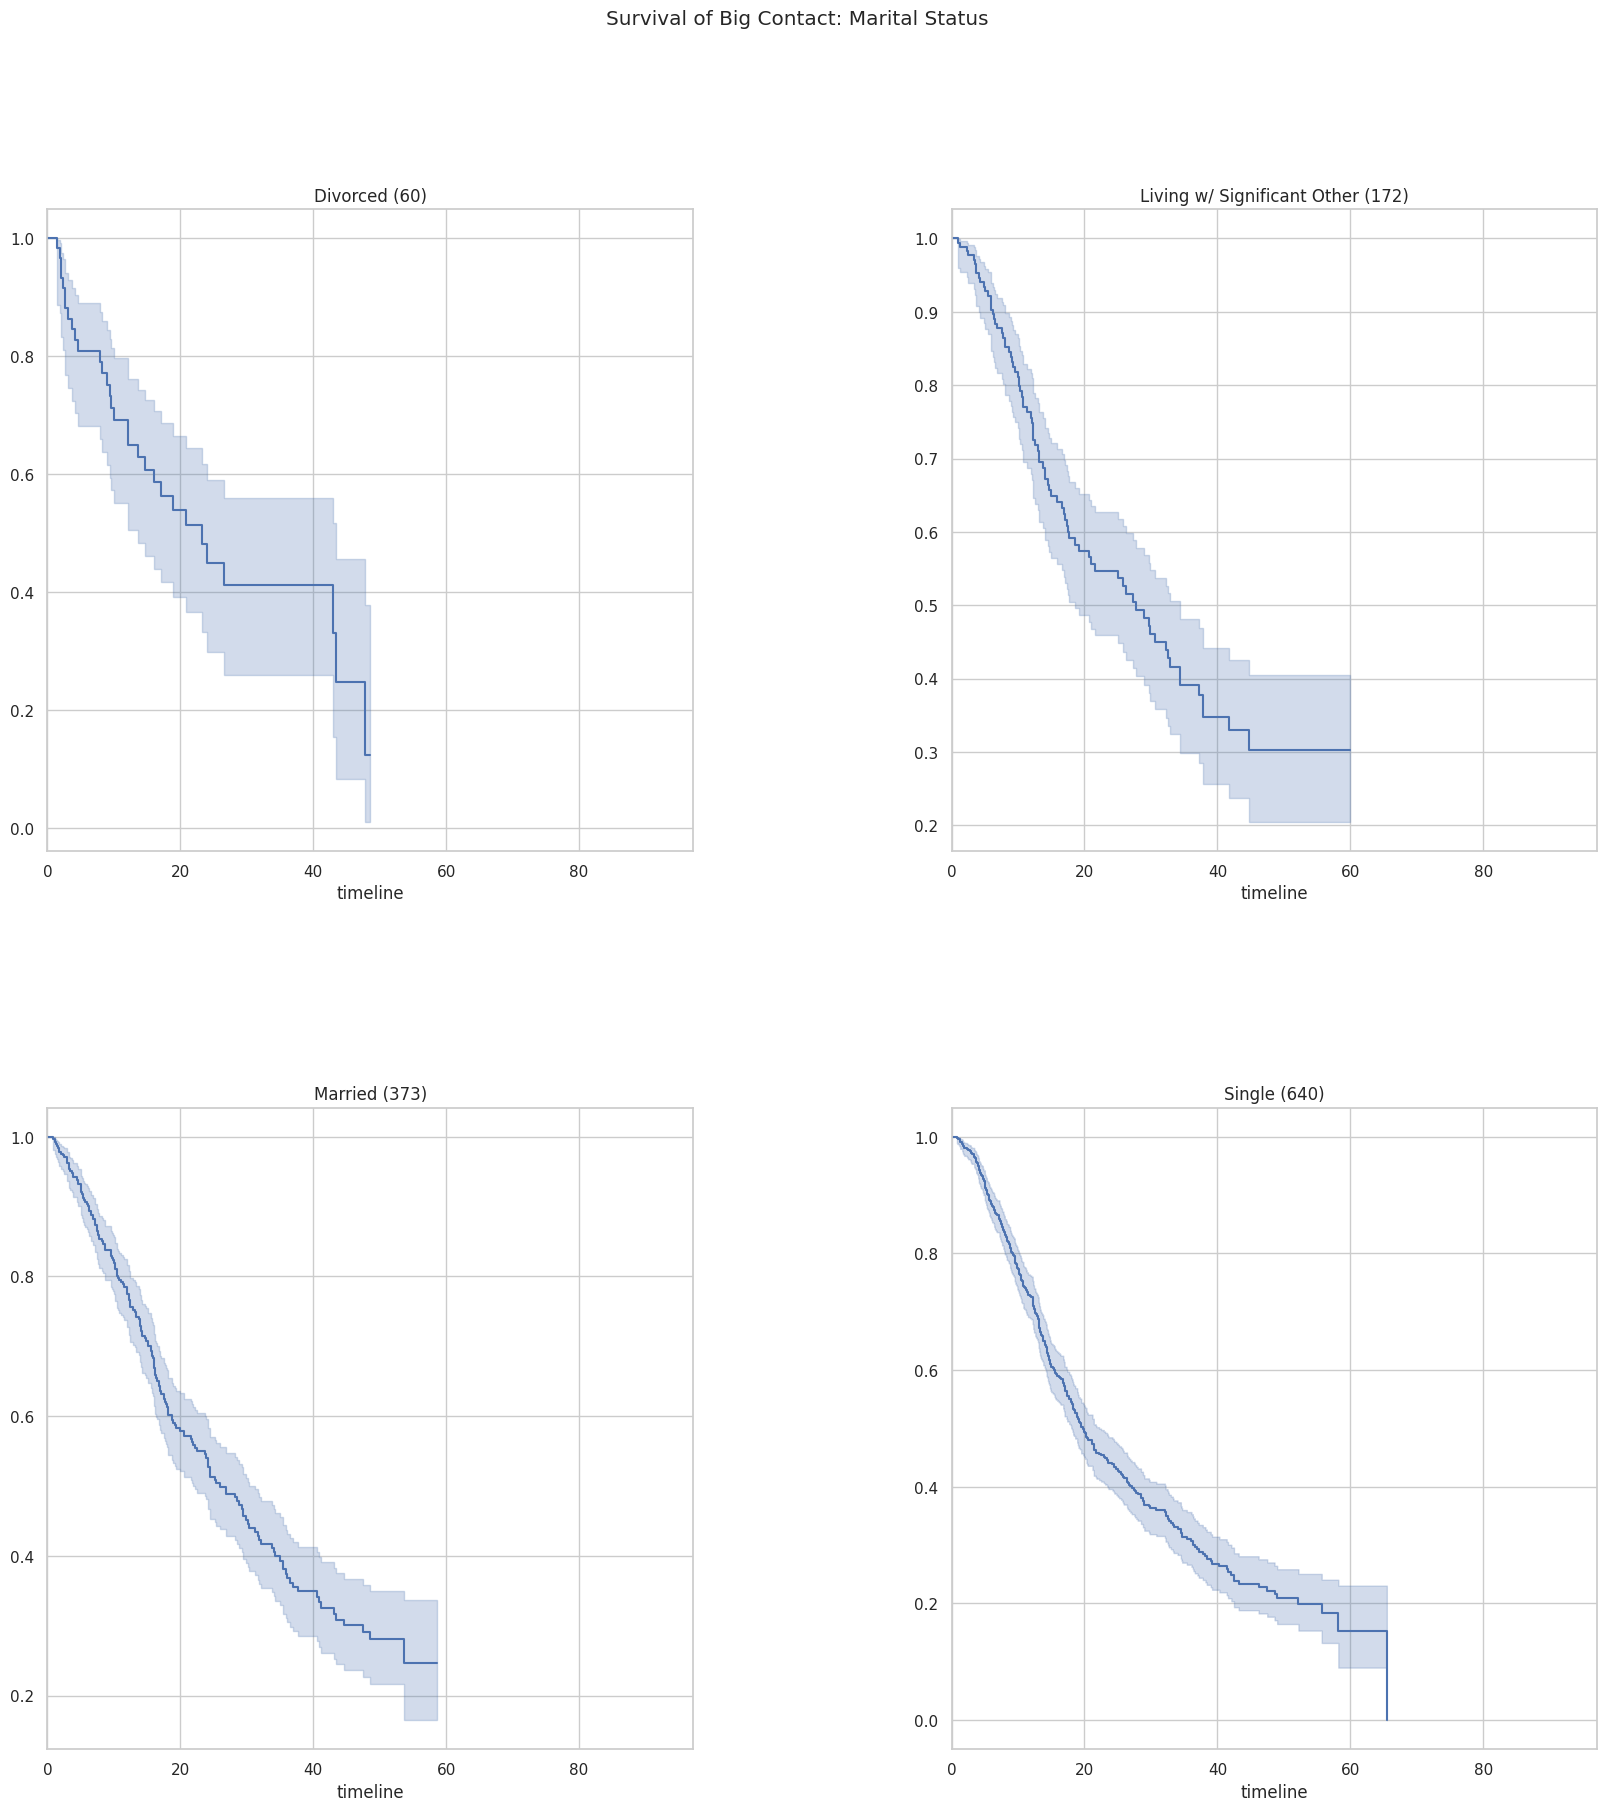

/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<Figure size 800x800 with 0 Axes>

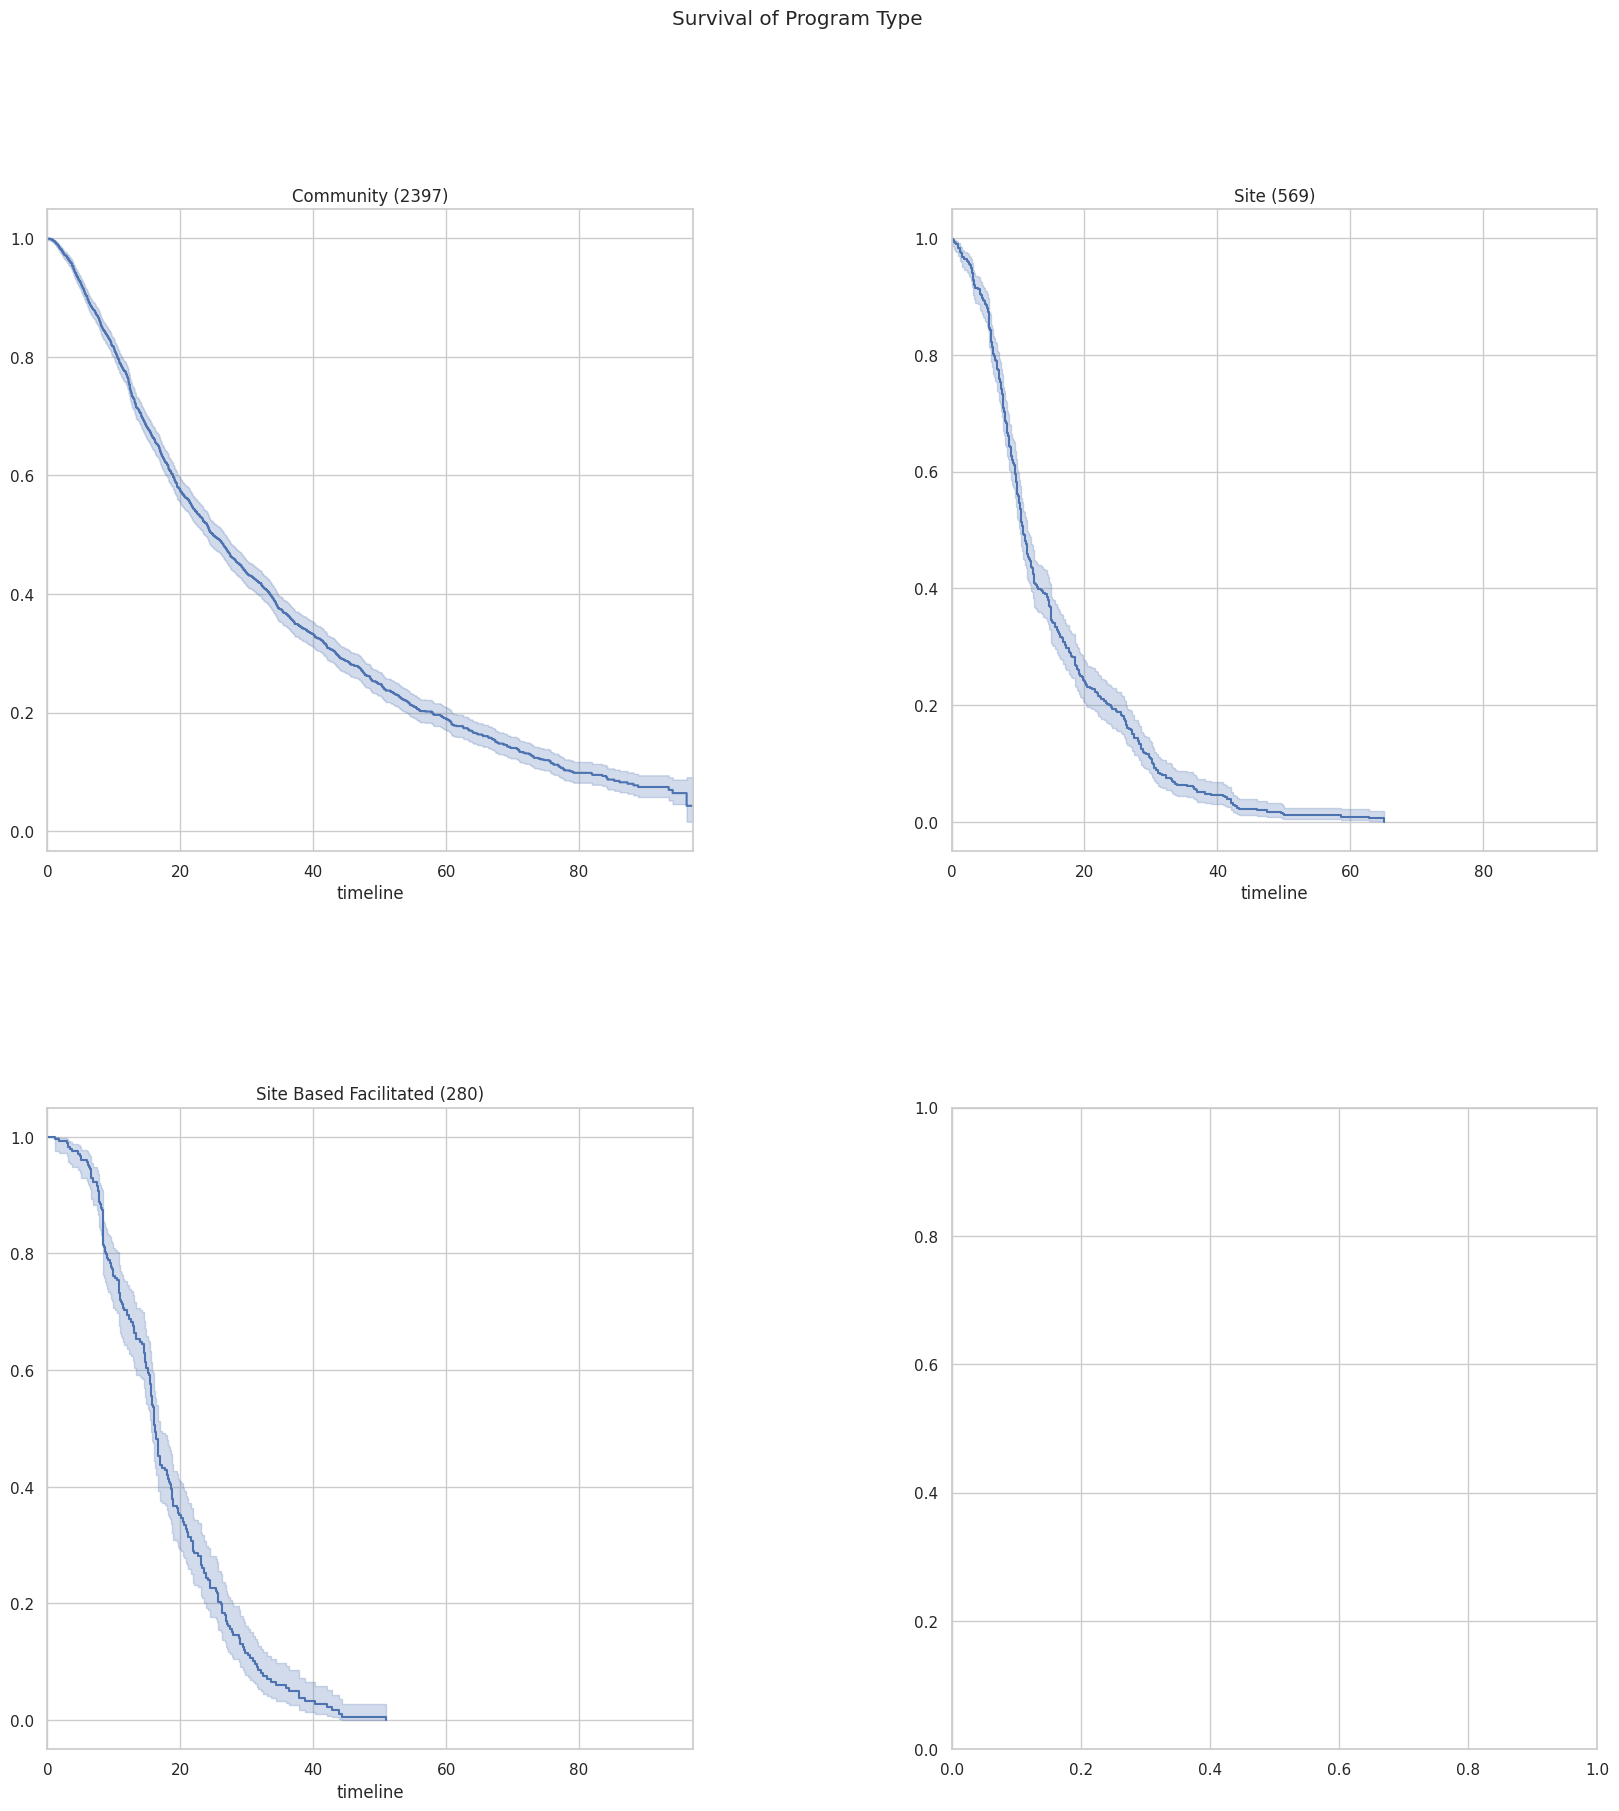

In [184]:
# Iterate over each category and its values

x_max = df_high_count['Match Length'].max()
for cat, vals in dem_cats.items():

    graphs_needed = len(vals)
    subplot_grid_len = int(np.ceil(graphs_needed ** 0.5))
    plt.figure(figsize=(subplot_grid_len*4, subplot_grid_len*4))
    fig, axes = plt.subplots(subplot_grid_len, subplot_grid_len, figsize=(20, 20))
    fig.suptitle(f"Survival of {cat}")
    # Flatten axes array for easy iteration if it's multidimensional
    axes = axes.flatten() if graphs_needed > 1 else [axes]

    # Plot each one-hot encoded column within the category
    for i, val in enumerate(vals):
        ax = axes[i]
        col_name = f"{cat}{subcategory_delimiter}{val}"
        if col_name in df_high_count.columns:
            df_ingroup = df_high_count[df_high_count[col_name] == 1]
            kmf.fit(durations = df_ingroup['Match Length'], event_observed = df_ingroup['Stage'], label = val)
            kmf.plot_survival_function(ax = ax, legend = False)
            ax.set_title(f"{val} ({len(df_ingroup)})")
            ax.set_xlim(0, x_max)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    plt.show()




In [185]:
import pandas as pd

# Consider the "... > Unknown" as the base categories, so remove it to calculate the impact of the other subcategories per demographic category.

# Extract columns where the part after ' >> '(the subcategory_delimiter) is 'Unknown'
unknown_columns = [col for col in df_high_count.columns if col.split(subcategory_delimiter)[-1] == 'Unknown']

# Extract Columns that CoxPHFitter identifies as having way too low variance, thus completely dictates completely determines whether a match closes or not.
too_low_variance_columns = ['Big Contact: Former Big/Little >> Former Little', 'Big Languages >> Somali', 'Little Participant: Race/Ethnicity >> Asian - Chinese', 'Big County >> Isanti', 'Big Level of Education >> Associate Degree']



# Filter the DataFrame to include only these columns
df_unknown = df_high_count[unknown_columns]

# Drop identified columns
df_known = df_high_count.drop(columns=unknown_columns)
# df_known = df_known.drop(columns=too_low_variance_columns)

print(df_known.shape)
print(df_unknown.shape)

(3249, 46)
(3249, 9)


In [186]:
# print(unknown_columns)
# print(df_known.head().to_markdown())
# print(df_unknown.head().to_markdown())
# print(df_known.columns)
# events = df_known['Stage'].astype(bool)
# print(df_known.loc[events, 'Big County >> Brown'].var())
# print(df_known.loc[~events, 'Big County >> Brown'].var())
# print(len(df_known[df_known['Big Level of Education >> Some High School'] == 1]))

In [187]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = df_known.drop('Closure Reason', axis = 1).corr(method='pearson')

# Display the correlation matrix
print(corr_matrix.to_markdown())

|                                                                                   |        Stage |   Match Length |     Big Age |   Big Gender |   Big Race/Ethnicity >> Asian |   Big Race/Ethnicity >> Asian - Other |   Big Race/Ethnicity >> Black or African American |   Big Race/Ethnicity >> Hispanic - Other Latinx or Spanish origin |   Big Race/Ethnicity >> Other |   Big Race/Ethnicity >> White or Caucasian |   Big Days Acceptance to Match |   Little Gender |   Little Participant: Race/Ethnicity >> Hispanic |   Little Participant: Race/Ethnicity >> Hispanic - Mexican,Mexican American,Chicano |   Little Participant: Race/Ethnicity >> Hispanic - Other Latinx or Spanish origin |   Little Participant: Race/Ethnicity >> Pacific Islander - Native Hawaiian |   Little Participant: Race/Ethnicity >> White or Caucasian |   Months Until Now |   Big County >> Anoka |   Big County >> Dakota |   Big County >> Hennepin |   Big County >> Ramsey |   Big County >> Washington |   Big Occupation >> Art

In [188]:
from lifelines import CoxPHFitter
cph = CoxPHFitter()
cph.fit(df_known.drop(columns=['Closure Reason']), duration_col = 'Match Length', event_col = 'Stage')
cph.print_summary()

/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<lifelines.CoxPHFitter: fitted with 3249 total observations, 764 right-censored observations>
             duration col = 'Match Length'
                event col = 'Stage'
      baseline estimation = breslow
   number of observations = 3249
number of events observed = 2485
   partial log-likelihood = -17666.32
         time fit was run = 2025-03-31 22:30:01 UTC

---
                                                                                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                                                          
Big Age                                                                           -0.01      0.99      0.00           -0.01           -0.00                0.99                1.00
Big Gender                                                                        -0.13      0.88      0.09           -0.31            0.05                0.74                1.06
Big Race/Ethnicity >> Asian                                                        0.04      1.05      0.14           -0.22            0.31                0.80                1.36
Big Race/Ethnicity >> Asian - Other                                               -0.36      0.70      0.17           -0.69           -0.02                0.50                0.98
Big Race/Ethnicity >> Black or African American                                   -0.07      0.93      0.13           -0.32            0.18                0.72                1.20
Big Race/Ethnicity >> Hispanic - Other Latinx or Spanish origin                   -0.41      0.66      0.22           -0.83            0.01                0.44                1.01
Big Race/Ethnicity >> Other                                                       -0.25      0.78      0.14           -0.53            0.03                0.59                1.03
Big Race/Ethnicity >> White or Caucasian                                          -0.41      0.67      0.11           -0.62           -0.19                0.54                0.83
Big Days Acceptance to Match                                                      -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
Little Gender                                                                      0.04      1.04      0.09           -0.14            0.22                0.87                1.24
Little Participant: Race/Ethnicity >> Hispanic                                    -0.26      0.77      0.10           -0.45           -0.07                0.64                0.94
Little Participant: Race/Ethnicity >> Hispanic - Mexican,Mexican American,Chicano -0.17      0.85      0.13           -0.41            0.08                0.66                1.08
Little Participant: Race/Ethnicity >> Hispanic - Other Latinx or Spanish origin    0.14      1.15      0.13           -0.11            0.39                0.90                1.48
Little Participant: Race/Ethnicity >> Pacific Islander - Native Hawaiian          -0.00      1.00      0.18           -0.35            0.34                0.71                1.41
Little Participant: Race/Ethnicity >> White or Caucasian                          -0.33      0.72      0.09           -0.51           -0.15                0.60                0.86
Months Until Now                                                                   0.00      1.00      0.00            0.00            0.01                1.00                1.01
Big County >> Anoka                                                                0.12      1.13      0.11           -0.09            0.34                0.91                1.40
Big County >> Dakota                                                               0.07      1.07      0.11           -0.14            0.27                0.87                1.32
Big County >> Hennepin        

In [191]:
print(df_known.columns)

Index(['Stage', 'Closure Reason', 'Match Length', 'Big Age', 'Big Gender',
       'Big Race/Ethnicity >> Asian', 'Big Race/Ethnicity >> Asian - Other',
       'Big Race/Ethnicity >> Black or African American',
       'Big Race/Ethnicity >> Hispanic - Other Latinx or Spanish origin',
       'Big Race/Ethnicity >> Other',
       'Big Race/Ethnicity >> White or Caucasian',
       'Big Days Acceptance to Match', 'Little Gender',
       'Little Participant: Race/Ethnicity >> Hispanic',
       'Little Participant: Race/Ethnicity >> Hispanic - Mexican,Mexican American,Chicano',
       'Little Participant: Race/Ethnicity >> Hispanic - Other Latinx or Spanish origin',
       'Little Participant: Race/Ethnicity >> Pacific Islander - Native Hawaiian',
       'Little Participant: Race/Ethnicity >> White or Caucasian',
       'Months Until Now', 'Big County >> Anoka', 'Big County >> Dakota',
       'Big County >> Hennepin', 'Big County >> Ramsey',
       'Big County >> Washington',
       'Big Occu